In [0]:
# Execute this code block to install dependencies when running on colab
try:
    import torch
except:
    from os.path import exists
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
    cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
    accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

    !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-1.0.0-{platform}-linux_x86_64.whl torchvision

try: 
    import torchbearer
except:
    !pip install torchbearer

In [0]:
# automatically reload external modules if they change
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchbearer
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torchbearer import Trial

In [0]:
# fix random seed for reproducibility
seed = 7
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [0]:
import torch
from torch.optim.optimizer import Optimizer, required


class SGD(Optimizer):
    r"""Implements stochastic gradient descent (optionally with momentum).

    Nesterov momentum is based on the formula from
    `On the importance of initialization and momentum in deep learning`__.

    Args:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float): learning rate
        momentum (float, optional): momentum factor (default: 0)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        dampening (float, optional): dampening for momentum (default: 0)
        nesterov (bool, optional): enables Nesterov momentum (default: False)

    Example:
        >>> optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
        >>> optimizer.zero_grad()
        >>> loss_fn(model(input), target).backward()
        >>> optimizer.step()

    __ http://www.cs.toronto.edu/%7Ehinton/absps/momentum.pdf

    .. note::
        The implementation of SGD with Momentum/Nesterov subtly differs from
        Sutskever et. al. and implementations in some other frameworks.

        Considering the specific case of Momentum, the update can be written as

        .. math::
                  v = \rho * v + g \\
                  p = p - lr * v

        where p, g, v and :math:`\rho` denote the parameters, gradient,
        velocity, and momentum respectively.

        This is in contrast to Sutskever et. al. and
        other frameworks which employ an update of the form

        .. math::
             v = \rho * v + lr * g \\
             p = p - v

        The Nesterov version is analogously modified.
    """
    #add heavy ball flag into dict param list
    def __init__(self, params, lr=required, momentum=0, dampening=0,
                 weight_decay=0, nesterov=False, heavy_ball=False):
        if lr is not required and lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if momentum < 0.0:
            raise ValueError("Invalid momentum value: {}".format(momentum))
        
        if weight_decay < 0.0:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))
        
        #deal with heavy ball flag
        defaults = dict(lr=lr, momentum=momentum, dampening=dampening,
                        weight_decay=weight_decay, nesterov=nesterov, 
                        heavy_ball=heavy_ball)
        
        #read heavy ball flag
        if heavy_ball and (momentum <= 0 or dampening != 0):
            raise ValueError("Heavy-ball momentum requires a momentum and zero dampening")

        if nesterov and (momentum <= 0 or dampening != 0):
            raise ValueError("Nesterov momentum requires a momentum and zero dampening")
        super(SGD, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(SGD, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('nesterov', False)
            group.setdefault('heavy_ball', False)

    def step(self, closure=None):
        """Performs a single optimization step.

        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            weight_decay = group['weight_decay']
            momentum = group['momentum']
            dampening = group['dampening']
            nesterov = group['nesterov']
            #read heavy ball flag
            heavy_ball = group['heavy_ball']

            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data
                if weight_decay != 0:
                    d_p.add_(weight_decay, p.data)
                if momentum != 0:
                    param_state = self.state[p]
                    if 'momentum_buffer' not in param_state:
                        buf = param_state['momentum_buffer'] = torch.clone(d_p).detach()
                        #init prev momentum space in GPU
                        param_state['prev_momentum_buffer'] = torch.zeros(buf.size()).cuda()
                    else:
                        buf = param_state['momentum_buffer']
                        #heavy ball iteration
                        prev_buf = param_state['prev_momentum_buffer']
                        if heavy_ball:
                            temp = buf
                            buf.add_(-prev_buf).mul_(momentum).add_(1 - dampening, d_p)
                            param_state['prev_momentum_buffer'] = temp
                        else:
                            buf.mul_(momentum).add_(1 - dampening, d_p)
                    if nesterov:
                        d_p = d_p.add(momentum, buf)
                    else:
                        d_p = buf

                p.data.add_(-group['lr'], d_p)

        return loss


In [0]:
from torch.optim.optimizer import Optimizer, required
import copy

class AccSGD(Optimizer):
    r"""Implements the algorithm proposed in https://arxiv.org/pdf/1704.08227.pdf, which is a provably accelerated method 
    for stochastic optimization. This has been employed in https://openreview.net/forum?id=rJTutzbA- for training several 
    deep learning models of practical interest. This code has been implemented by building on the construction of the SGD 
    optimization module found in pytorch codebase.
    Args:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float): learning rate (required)
        kappa (float, optional): ratio of long to short step (default: 1000)
        xi (float, optional): statistical advantage parameter (default: 10)
        smallConst (float, optional): any value <=1 (default: 0.7)
    Example:
        >>> from AccSGD import *
        >>> optimizer = AccSGD(model.parameters(), lr=0.1, kappa = 1000.0, xi = 10.0)
        >>> optimizer.zero_grad()
        >>> loss_fn(model(input), target).backward()
        >>> optimizer.step()
    """

    def __init__(self, params, lr=0.001, kappa = 1000.0, xi = 10.0, smallConst = 0.7, weight_decay=0):
        defaults = dict(lr=lr, kappa=kappa, xi=xi, smallConst=smallConst,
                        weight_decay=weight_decay)
        super(AccSGD, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(AccSGD, self).__setstate__(state)

    def step(self, closure=None):
        """ Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            weight_decay = group['weight_decay']
            large_lr = (group['lr']*group['kappa'])/(group['smallConst'])
            Alpha = 1.0 - ((group['smallConst']*group['smallConst']*group['xi'])/group['kappa'])
            Beta = 1.0 - Alpha
            zeta = group['smallConst']/(group['smallConst']+Beta)
            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data
                if weight_decay != 0:
                    d_p.add_(weight_decay, p.data)
                param_state = self.state[p]
                if 'momentum_buffer' not in param_state:
                    param_state['momentum_buffer'] = copy.deepcopy(p.data)
                buf = param_state['momentum_buffer']
                buf.mul_((1.0/Beta)-1.0)
                buf.add_(-large_lr,d_p)
                buf.add_(p.data)
                buf.mul_(Beta)

                p.data.add_(-group['lr'],d_p)
                p.data.mul_(zeta)
                p.data.add_(1.0-zeta,buf)

        return loss

In [0]:
import torch
import torch.nn as nn

class DownsampleA(nn.Module):  

  def __init__(self, nIn, nOut, stride):
    super(DownsampleA, self).__init__() 
    assert stride == 2    
    self.avg = nn.AvgPool2d(kernel_size=1, stride=stride)   

  def forward(self, x):   
    x = self.avg(x)  
    return torch.cat((x, x.mul(0)), 1)  

class DownsampleC(nn.Module):     

  def __init__(self, nIn, nOut, stride):
    super(DownsampleC, self).__init__()
    assert stride != 1 or nIn != nOut
    self.conv = nn.Conv2d(nIn, nOut, kernel_size=1, stride=stride, padding=0, bias=False)

  def forward(self, x):
    x = self.conv(x)
    return x

class DownsampleD(nn.Module):

  def __init__(self, nIn, nOut, stride):
    super(DownsampleD, self).__init__()
    assert stride == 2
    self.conv = nn.Conv2d(nIn, nOut, kernel_size=2, stride=stride, padding=0, bias=False)
    self.bn   = nn.BatchNorm2d(nOut)

  def forward(self, x):
    x = self.conv(x)
    x = self.bn(x)
    return x

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
# from .res_utils import DownsampleA, DownsampleC
import math


class ResNetBasicblock(nn.Module):
  expansion = 1
  def __init__(self, inplanes, planes, stride, downsample, Type):
    super(ResNetBasicblock, self).__init__()

    self.Type = Type

    self.bn_a = nn.BatchNorm2d(inplanes)
    self.conv_a = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride, padding=1, bias=False)

    self.bn_b = nn.BatchNorm2d(planes)
    self.conv_b = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)

    self.relu = nn.ReLU(inplace=True)
    self.downsample = downsample

  def forward(self, x):
    residual = x

    basicblock = self.bn_a(x)
    basicblock = self.relu(basicblock)

    if self.Type == 'both_preact':
      residual = basicblock
    elif self.Type != 'normal':
      assert False, 'Unknow type : {}'.format(self.Type)

    basicblock = self.conv_a(basicblock)

    basicblock = self.bn_b(basicblock)
    basicblock = self.relu(basicblock)
    basicblock = self.conv_b(basicblock)

    if self.downsample is not None:
      residual = self.downsample(residual)
    
    return residual + basicblock

class CifarPreResNet(nn.Module):
  """
  ResNet optimized for the Cifar dataset, as specified in
  https://arxiv.org/abs/1512.03385.pdf
  """
  def __init__(self, block, depth, num_classes):
    """ Constructor
    Args:
      depth: number of layers.
      num_classes: number of classes
      base_width: base width
    """
    super(CifarPreResNet, self).__init__()

    #Model type specifies number of layers for CIFAR-10 and CIFAR-100 model
    assert (depth - 2) % 6 == 0, 'depth should be one of 20, 32, 44, 56, 110'
    layer_blocks = (depth - 2) // 6
    print ('CifarPreResNet : Depth : {} , Layers for each block : {}'.format(depth, layer_blocks))

    self.num_classes = num_classes

    self.conv_3x3 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)

    self.inplanes = 16
    self.stage_1 = self._make_layer(block, 16, layer_blocks, 1)
    self.stage_2 = self._make_layer(block, 32, layer_blocks, 2)
    self.stage_3 = self._make_layer(block, 64, layer_blocks, 2)
    self.lastact = nn.Sequential(nn.BatchNorm2d(64*block.expansion), nn.ReLU(inplace=True))
    self.avgpool = nn.AvgPool2d(8)
    self.classifier = nn.Linear(64*block.expansion, num_classes)

    for m in self.modules():
      if isinstance(m, nn.Conv2d):
        n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
        m.weight.data.normal_(0, math.sqrt(2. / n))
        #m.bias.data.zero_()
      elif isinstance(m, nn.BatchNorm2d):
        m.weight.data.fill_(1)
        m.bias.data.zero_()
      elif isinstance(m, nn.Linear):
        init.kaiming_normal(m.weight)
        m.bias.data.zero_()

  def _make_layer(self, block, planes, blocks, stride=1):
    downsample = None
    if stride != 1 or self.inplanes != planes * block.expansion:
      downsample = DownsampleA(self.inplanes, planes * block.expansion, stride)

    layers = []
    layers.append(block(self.inplanes, planes, stride, downsample, 'both_preact'))
    self.inplanes = planes * block.expansion
    for i in range(1, blocks):
      layers.append(block(self.inplanes, planes, 1, None, 'normal'))

    return nn.Sequential(*layers)

  def forward(self, x):
    x = self.conv_3x3(x)
    x = self.stage_1(x)
    x = self.stage_2(x)
    x = self.stage_3(x)
    x = self.lastact(x)
    x = self.avgpool(x)
    x = x.view(x.size(0), -1)
    return self.classifier(x)


In [0]:
import torchvision.transforms as transforms
import torchvision.datasets as dset

num_classes = 10
seed = 7
batch_size = 16

mean = [x / 255 for x in [125.3, 123.0, 113.9]]
std = [x / 255 for x in [63.0, 62.1, 66.7]]

train_transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(), transforms.RandomCrop(32, padding=4), transforms.ToTensor(),
     transforms.Normalize(mean, std)])
test_transform = transforms.Compose(
  [transforms.ToTensor(), transforms.Normalize(mean, std)])

train_data = dset.CIFAR10(".", train=True, transform=train_transform, download=True)
test_data = dset.CIFAR10(".", train=False, transform=test_transform, download=True)




Files already downloaded and verified
Files already downloaded and verified


In [0]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, pin_memory=True)


In [0]:
# HB
# build the model
model = CifarPreResNet(ResNetBasicblock, 44, num_classes)
model.eval()
learn_rate=[0.27,0.09,0.03,0.01]
momentum = [0.97,0.95,0.9,0.8,0.5]
xxHB = np.zeros((20,1))
yyHB = np.zeros((20,1))
# build the model
loss_function = nn.CrossEntropyLoss()
device = "cuda:0" if torch.cuda.is_available() else "cpu"
# optimiser = optim.Adam(model.parameters())
ll=0
mm=0
loss = 100
loss_pre = 100
for e in range(0,20):
  #print('epoch=',e)
  model1 = copy.deepcopy(model)
  #print(list(model.parameters())[0][0])
  #print(list(model1.parameters())[0][0])
  i = learn_rate[ll]
  j = momentum[mm]
  optimiser = SGD(model.parameters(), lr=i, momentum=j, heavy_ball=True)
  trial = Trial(model, optimiser, loss_function, metrics=['loss', 'accuracy']).to(device)
  trial.with_generators(train_loader, test_generator=test_loader)
  result = trial.run(epochs=1)
  #print(i)
  if e%3==0:
    pre_loss = loss
    if ((loss_pre-loss)/loss_pre<0.01 and ll<3 ):
      if(mm<4):
        mm = mm+1
      else:
        mm = 0
        ll = ll+1
  loss = result[0][1]['loss']
  xxHB[e] = e
  yyHB[e] = result[0][1]['loss']
    
  print('loss=',loss)

CifarPreResNet : Depth : 44 , Layers for each block : 7
epoch= 0
tensor([[[-0.1389, -0.2431, -0.0799],
         [ 0.0058,  0.0617,  0.1430],
         [-0.1659, -0.0471,  0.0212]],

        [[-0.0925, -0.1156, -0.0113],
         [-0.2464, -0.0139, -0.0125],
         [-0.0042,  0.1055,  0.0687]],

        [[-0.0085, -0.0313,  0.1585],
         [ 0.1083,  0.1616, -0.1053],
         [ 0.0495,  0.0931, -0.1051]]], grad_fn=<SelectBackward>)
tensor([[[-0.1389, -0.2431, -0.0799],
         [ 0.0058,  0.0617,  0.1430],
         [-0.1659, -0.0471,  0.0212]],

        [[-0.0925, -0.1156, -0.0113],
         [-0.2464, -0.0139, -0.0125],
         [-0.0042,  0.1055,  0.0687]],

        [[-0.0085, -0.0313,  0.1585],
         [ 0.1083,  0.1616, -0.1053],
         [ 0.0495,  0.0931, -0.1051]]], grad_fn=<SelectBackward>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:87: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


0.27
loss= 1.6510982513427734
epoch= 1
tensor([[[-0.2590, -0.2461, -0.2630],
         [-0.3563, -0.1861, -0.2174],
         [-0.4746, -0.3154, -0.3613]],

        [[-0.0576,  0.1229, -0.0428],
         [-0.2926,  0.1374, -0.0865],
         [-0.1503,  0.0727, -0.1792]],

        [[ 0.4083,  0.7259,  0.6798],
         [ 0.5614,  0.9534,  0.4738],
         [ 0.3395,  0.6462,  0.2451]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[-0.2590, -0.2461, -0.2630],
         [-0.3563, -0.1861, -0.2174],
         [-0.4746, -0.3154, -0.3613]],

        [[-0.0576,  0.1229, -0.0428],
         [-0.2926,  0.1374, -0.0865],
         [-0.1503,  0.0727, -0.1792]],

        [[ 0.4083,  0.7259,  0.6798],
         [ 0.5614,  0.9534,  0.4738],
         [ 0.3395,  0.6462,  0.2451]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.27
loss= 1.0723824501037598
epoch= 2
tensor([[[-0.4124, -0.4440, -0.5576],
         [-0.6133, -0.3563, -0.5431],
         [-0.6350, -0.4528, -0.5808]],

        [[-0.0836,  0.1147, -0.1889],
         [-0.3980,  0.2168, -0.2064],
         [-0.2295,  0.0855, -0.2575]],

        [[ 0.3728,  0.7259,  0.5577],
         [ 0.5174,  1.0957,  0.4130],
         [ 0.3235,  0.7320,  0.2031]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[-0.4124, -0.4440, -0.5576],
         [-0.6133, -0.3563, -0.5431],
         [-0.6350, -0.4528, -0.5808]],

        [[-0.0836,  0.1147, -0.1889],
         [-0.3980,  0.2168, -0.2064],
         [-0.2295,  0.0855, -0.2575]],

        [[ 0.3728,  0.7259,  0.5577],
         [ 0.5174,  1.0957,  0.4130],
         [ 0.3235,  0.7320,  0.2031]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.27
loss= 0.8378140926361084
epoch= 3
tensor([[[-0.3192, -0.4863, -0.6577],
         [-0.6526, -0.3722, -0.6251],
         [-0.6798, -0.4008, -0.5353]],

        [[ 0.0178,  0.1141, -0.2375],
         [-0.4237,  0.2794, -0.2260],
         [-0.2890,  0.1896, -0.1769]],

        [[ 0.5103,  0.7530,  0.5169],
         [ 0.5888,  1.2358,  0.4382],
         [ 0.3735,  0.9320,  0.3334]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[-0.3192, -0.4863, -0.6577],
         [-0.6526, -0.3722, -0.6251],
         [-0.6798, -0.4008, -0.5353]],

        [[ 0.0178,  0.1141, -0.2375],
         [-0.4237,  0.2794, -0.2260],
         [-0.2890,  0.1896, -0.1769]],

        [[ 0.5103,  0.7530,  0.5169],
         [ 0.5888,  1.2358,  0.4382],
         [ 0.3735,  0.9320,  0.3334]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.27
loss= 0.7237318754196167
epoch= 4
tensor([[[-0.2717, -0.4073, -0.6569],
         [-0.6376, -0.3266, -0.6578],
         [-0.6362, -0.3807, -0.5450]],

        [[ 0.0605,  0.2245, -0.1908],
         [-0.4268,  0.3576, -0.2429],
         [-0.3289,  0.1599, -0.2414]],

        [[ 0.5728,  0.8749,  0.5558],
         [ 0.6750,  1.3879,  0.4792],
         [ 0.4273,  0.9985,  0.3474]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[-0.2717, -0.4073, -0.6569],
         [-0.6376, -0.3266, -0.6578],
         [-0.6362, -0.3807, -0.5450]],

        [[ 0.0605,  0.2245, -0.1908],
         [-0.4268,  0.3576, -0.2429],
         [-0.3289,  0.1599, -0.2414]],

        [[ 0.5728,  0.8749,  0.5558],
         [ 0.6750,  1.3879,  0.4792],
         [ 0.4273,  0.9985,  0.3474]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.27
loss= 0.6472797989845276
epoch= 5
tensor([[[-0.2778, -0.4828, -0.7786],
         [-0.6758, -0.4061, -0.7745],
         [-0.6012, -0.4498, -0.6071]],

        [[ 0.0681,  0.2419, -0.2614],
         [-0.4397,  0.3829, -0.2905],
         [-0.3274,  0.1213, -0.2953]],

        [[ 0.5720,  0.9016,  0.4698],
         [ 0.6848,  1.4573,  0.4503],
         [ 0.4488,  1.0183,  0.3317]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[-0.2778, -0.4828, -0.7786],
         [-0.6758, -0.4061, -0.7745],
         [-0.6012, -0.4498, -0.6071]],

        [[ 0.0681,  0.2419, -0.2614],
         [-0.4397,  0.3829, -0.2905],
         [-0.3274,  0.1213, -0.2953]],

        [[ 0.5720,  0.9016,  0.4698],
         [ 0.6848,  1.4573,  0.4503],
         [ 0.4488,  1.0183,  0.3317]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.27
loss= 0.5958477258682251
epoch= 6
tensor([[[-0.3185, -0.5496, -0.8413],
         [-0.7073, -0.4577, -0.8533],
         [-0.5564, -0.4585, -0.6149]],

        [[ 0.0704,  0.2290, -0.2732],
         [-0.4188,  0.4206, -0.3085],
         [-0.3153,  0.1284, -0.3127]],

        [[ 0.5525,  0.9215,  0.4794],
         [ 0.7188,  1.5653,  0.4831],
         [ 0.4612,  1.1038,  0.3519]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[-0.3185, -0.5496, -0.8413],
         [-0.7073, -0.4577, -0.8533],
         [-0.5564, -0.4585, -0.6149]],

        [[ 0.0704,  0.2290, -0.2732],
         [-0.4188,  0.4206, -0.3085],
         [-0.3153,  0.1284, -0.3127]],

        [[ 0.5525,  0.9215,  0.4794],
         [ 0.7188,  1.5653,  0.4831],
         [ 0.4612,  1.1038,  0.3519]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.27
loss= 0.548720121383667
epoch= 7
tensor([[[-0.2718, -0.5549, -0.7583],
         [-0.7384, -0.5107, -0.8546],
         [-0.5459, -0.5033, -0.6230]],

        [[ 0.1300,  0.2453, -0.2153],
         [-0.4215,  0.4111, -0.3290],
         [-0.2951,  0.0940, -0.3572]],

        [[ 0.6339,  0.9792,  0.5272],
         [ 0.7859,  1.6366,  0.5015],
         [ 0.5495,  1.1525,  0.3536]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[-0.2718, -0.5549, -0.7583],
         [-0.7384, -0.5107, -0.8546],
         [-0.5459, -0.5033, -0.6230]],

        [[ 0.1300,  0.2453, -0.2153],
         [-0.4215,  0.4111, -0.3290],
         [-0.2951,  0.0940, -0.3572]],

        [[ 0.6339,  0.9792,  0.5272],
         [ 0.7859,  1.6366,  0.5015],
         [ 0.5495,  1.1525,  0.3536]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.27
loss= 0.5151447653770447
epoch= 8
tensor([[[-0.2524, -0.5485, -0.7535],
         [-0.7366, -0.5449, -0.9121],
         [-0.4997, -0.5064, -0.6070]],

        [[ 0.1739,  0.3057, -0.1572],
         [-0.3960,  0.4349, -0.3347],
         [-0.2804,  0.0751, -0.3605]],

        [[ 0.6729,  1.0332,  0.5855],
         [ 0.8428,  1.7046,  0.5422],
         [ 0.5531,  1.1627,  0.3544]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[-0.2524, -0.5485, -0.7535],
         [-0.7366, -0.5449, -0.9121],
         [-0.4997, -0.5064, -0.6070]],

        [[ 0.1739,  0.3057, -0.1572],
         [-0.3960,  0.4349, -0.3347],
         [-0.2804,  0.0751, -0.3605]],

        [[ 0.6729,  1.0332,  0.5855],
         [ 0.8428,  1.7046,  0.5422],
         [ 0.5531,  1.1627,  0.3544]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.27
loss= 0.48241138458251953
epoch= 9
tensor([[[-0.2841, -0.6121, -0.8126],
         [-0.8019, -0.6119, -0.9844],
         [-0.5312, -0.5345, -0.6141]],

        [[ 0.2027,  0.3071, -0.1884],
         [-0.4081,  0.4406, -0.3547],
         [-0.2835,  0.0715, -0.3435]],

        [[ 0.6339,  1.0227,  0.4897],
         [ 0.8020,  1.7284,  0.4874],
         [ 0.5330,  1.1982,  0.3472]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[-0.2841, -0.6121, -0.8126],
         [-0.8019, -0.6119, -0.9844],
         [-0.5312, -0.5345, -0.6141]],

        [[ 0.2027,  0.3071, -0.1884],
         [-0.4081,  0.4406, -0.3547],
         [-0.2835,  0.0715, -0.3435]],

        [[ 0.6339,  1.0227,  0.4897],
         [ 0.8020,  1.7284,  0.4874],
         [ 0.5330,  1.1982,  0.3472]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.27
loss= 0.4564002752304077
epoch= 10
tensor([[[-0.3352, -0.5734, -0.7245],
         [-0.8016, -0.6060, -0.9525],
         [-0.4933, -0.5858, -0.6399]],

        [[ 0.2072,  0.3931, -0.0665],
         [-0.3580,  0.5157, -0.2690],
         [-0.2027,  0.0649, -0.3297]],

        [[ 0.6222,  1.1038,  0.5561],
         [ 0.8133,  1.8197,  0.5577],
         [ 0.5737,  1.2215,  0.3492]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[-0.3352, -0.5734, -0.7245],
         [-0.8016, -0.6060, -0.9525],
         [-0.4933, -0.5858, -0.6399]],

        [[ 0.2072,  0.3931, -0.0665],
         [-0.3580,  0.5157, -0.2690],
         [-0.2027,  0.0649, -0.3297]],

        [[ 0.6222,  1.1038,  0.5561],
         [ 0.8133,  1.8197,  0.5577],
         [ 0.5737,  1.2215,  0.3492]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.27
loss= 0.4315050542354584
epoch= 11
tensor([[[-0.3379, -0.6005, -0.7975],
         [-0.8184, -0.6582, -1.0274],
         [-0.4901, -0.6583, -0.6805]],

        [[ 0.2306,  0.4036, -0.1369],
         [-0.3324,  0.5195, -0.3585],
         [-0.1931,  0.0136, -0.3935]],

        [[ 0.6118,  1.1007,  0.5004],
         [ 0.8377,  1.8285,  0.4918],
         [ 0.6098,  1.2037,  0.2956]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[-0.3379, -0.6005, -0.7975],
         [-0.8184, -0.6582, -1.0274],
         [-0.4901, -0.6583, -0.6805]],

        [[ 0.2306,  0.4036, -0.1369],
         [-0.3324,  0.5195, -0.3585],
         [-0.1931,  0.0136, -0.3935]],

        [[ 0.6118,  1.1007,  0.5004],
         [ 0.8377,  1.8285,  0.4918],
         [ 0.6098,  1.2037,  0.2956]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.27
loss= 0.4059602618217468
epoch= 12
tensor([[[-0.2934, -0.5611, -0.7962],
         [-0.8748, -0.7184, -1.0261],
         [-0.5369, -0.7595, -0.6740]],

        [[ 0.2966,  0.4661, -0.1266],
         [-0.3452,  0.5123, -0.3707],
         [-0.2254, -0.0580, -0.4140]],

        [[ 0.6555,  1.1584,  0.4928],
         [ 0.8015,  1.8445,  0.4860],
         [ 0.5500,  1.1808,  0.2782]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[-0.2934, -0.5611, -0.7962],
         [-0.8748, -0.7184, -1.0261],
         [-0.5369, -0.7595, -0.6740]],

        [[ 0.2966,  0.4661, -0.1266],
         [-0.3452,  0.5123, -0.3707],
         [-0.2254, -0.0580, -0.4140]],

        [[ 0.6555,  1.1584,  0.4928],
         [ 0.8015,  1.8445,  0.4860],
         [ 0.5500,  1.1808,  0.2782]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.27
loss= 0.3928387761116028
epoch= 13
tensor([[[-0.3439, -0.6093, -0.8063],
         [-0.8958, -0.7533, -1.0146],
         [-0.4529, -0.6949, -0.5795]],

        [[ 0.3041,  0.4760, -0.1026],
         [-0.3437,  0.5037, -0.3713],
         [-0.1580, -0.0166, -0.3773]],

        [[ 0.6770,  1.1996,  0.5423],
         [ 0.8262,  1.8732,  0.5082],
         [ 0.6353,  1.2596,  0.3237]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[-0.3439, -0.6093, -0.8063],
         [-0.8958, -0.7533, -1.0146],
         [-0.4529, -0.6949, -0.5795]],

        [[ 0.3041,  0.4760, -0.1026],
         [-0.3437,  0.5037, -0.3713],
         [-0.1580, -0.0166, -0.3773]],

        [[ 0.6770,  1.1996,  0.5423],
         [ 0.8262,  1.8732,  0.5082],
         [ 0.6353,  1.2596,  0.3237]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.27
loss= 0.37133416533470154
epoch= 14
tensor([[[-0.3850, -0.6511, -0.8585],
         [-0.9332, -0.7954, -1.0800],
         [-0.4560, -0.7272, -0.6269]],

        [[ 0.2906,  0.4885, -0.1253],
         [-0.3638,  0.5154, -0.4150],
         [-0.1731, -0.0361, -0.4260]],

        [[ 0.6245,  1.1904,  0.5053],
         [ 0.7961,  1.8774,  0.4558],
         [ 0.6353,  1.2667,  0.2862]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[-0.3850, -0.6511, -0.8585],
         [-0.9332, -0.7954, -1.0800],
         [-0.4560, -0.7272, -0.6269]],

        [[ 0.2906,  0.4885, -0.1253],
         [-0.3638,  0.5154, -0.4150],
         [-0.1731, -0.0361, -0.4260]],

        [[ 0.6245,  1.1904,  0.5053],
         [ 0.7961,  1.8774,  0.4558],
         [ 0.6353,  1.2667,  0.2862]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.27
loss= 0.3568980097770691
epoch= 15
tensor([[[-0.4153, -0.6603, -0.8673],
         [-0.9623, -0.8005, -1.0986],
         [-0.4650, -0.7330, -0.6208]],

        [[ 0.2979,  0.5042, -0.1353],
         [-0.3559,  0.5430, -0.4157],
         [-0.1487, -0.0346, -0.4387]],

        [[ 0.6247,  1.2330,  0.5000],
         [ 0.8024,  1.9196,  0.4408],
         [ 0.6472,  1.2642,  0.2345]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[-0.4153, -0.6603, -0.8673],
         [-0.9623, -0.8005, -1.0986],
         [-0.4650, -0.7330, -0.6208]],

        [[ 0.2979,  0.5042, -0.1353],
         [-0.3559,  0.5430, -0.4157],
         [-0.1487, -0.0346, -0.4387]],

        [[ 0.6247,  1.2330,  0.5000],
         [ 0.8024,  1.9196,  0.4408],
         [ 0.6472,  1.2642,  0.2345]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.27
loss= 0.34404757618904114
epoch= 16
tensor([[[-0.3973, -0.6287, -0.8182],
         [-1.0026, -0.8419, -1.1494],
         [-0.4396, -0.7612, -0.6328]],

        [[ 0.3425,  0.5505, -0.0819],
         [-0.3649,  0.5424, -0.4474],
         [-0.1066, -0.0286, -0.4413]],

        [[ 0.6273,  1.2643,  0.5131],
         [ 0.7904,  1.9275,  0.3846],
         [ 0.7103,  1.2949,  0.2065]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[-0.3973, -0.6287, -0.8182],
         [-1.0026, -0.8419, -1.1494],
         [-0.4396, -0.7612, -0.6328]],

        [[ 0.3425,  0.5505, -0.0819],
         [-0.3649,  0.5424, -0.4474],
         [-0.1066, -0.0286, -0.4413]],

        [[ 0.6273,  1.2643,  0.5131],
         [ 0.7904,  1.9275,  0.3846],
         [ 0.7103,  1.2949,  0.2065]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.27
loss= 0.32814499735832214
epoch= 17
tensor([[[-0.3721, -0.5789, -0.7553],
         [-1.0161, -0.8552, -1.1761],
         [-0.4140, -0.8162, -0.6873]],

        [[ 0.3967,  0.6100, -0.0028],
         [-0.3616,  0.5644, -0.4261],
         [-0.0882, -0.0525, -0.4563]],

        [[ 0.6793,  1.3215,  0.5684],
         [ 0.7786,  1.9569,  0.4085],
         [ 0.7013,  1.2874,  0.1772]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[-0.3721, -0.5789, -0.7553],
         [-1.0161, -0.8552, -1.1761],
         [-0.4140, -0.8162, -0.6873]],

        [[ 0.3967,  0.6100, -0.0028],
         [-0.3616,  0.5644, -0.4261],
         [-0.0882, -0.0525, -0.4563]],

        [[ 0.6793,  1.3215,  0.5684],
         [ 0.7786,  1.9569,  0.4085],
         [ 0.7013,  1.2874,  0.1772]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.27
loss= 0.31719571352005005
epoch= 18
tensor([[[-0.3439, -0.6092, -0.7567],
         [-1.0027, -0.8915, -1.1886],
         [-0.3989, -0.8310, -0.7005]],

        [[ 0.4317,  0.6074,  0.0088],
         [-0.3348,  0.5766, -0.4190],
         [-0.0791, -0.0567, -0.4898]],

        [[ 0.7178,  1.3464,  0.5703],
         [ 0.7993,  2.0021,  0.4172],
         [ 0.6867,  1.3112,  0.1470]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[-0.3439, -0.6092, -0.7567],
         [-1.0027, -0.8915, -1.1886],
         [-0.3989, -0.8310, -0.7005]],

        [[ 0.4317,  0.6074,  0.0088],
         [-0.3348,  0.5766, -0.4190],
         [-0.0791, -0.0567, -0.4898]],

        [[ 0.7178,  1.3464,  0.5703],
         [ 0.7993,  2.0021,  0.4172],
         [ 0.6867,  1.3112,  0.1470]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.27
loss= 0.3042997717857361
epoch= 19
tensor([[[-0.3884, -0.5983, -0.7573],
         [-1.0096, -0.8579, -1.1541],
         [-0.4157, -0.8165, -0.6400]],

        [[ 0.4074,  0.6563,  0.0157],
         [-0.3278,  0.6584, -0.3539],
         [-0.0723,  0.0108, -0.4034]],

        [[ 0.7119,  1.4050,  0.5482],
         [ 0.8378,  2.0844,  0.4387],
         [ 0.7006,  1.3585,  0.1733]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[-0.3884, -0.5983, -0.7573],
         [-1.0096, -0.8579, -1.1541],
         [-0.4157, -0.8165, -0.6400]],

        [[ 0.4074,  0.6563,  0.0157],
         [-0.3278,  0.6584, -0.3539],
         [-0.0723,  0.0108, -0.4034]],

        [[ 0.7119,  1.4050,  0.5482],
         [ 0.8378,  2.0844,  0.4387],
         [ 0.7006,  1.3585,  0.1733]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.27
loss= 0.2970149517059326


In [0]:
# NAG
# build the model
model = CifarPreResNet(ResNetBasicblock, 44, num_classes)
model.eval()
learn_rate=[0.27,0.09,0.03,0.01]
momentum = [0.97,0.95,0.9,0.8,0.5]
xxNAG = np.zeros((20,1))
yyNAG = np.zeros((20,1))
# build the model
loss_function = nn.CrossEntropyLoss()
device = "cuda:0" if torch.cuda.is_available() else "cpu"
# optimiser = optim.Adam(model.parameters())
ll=0
mm=0
loss = 100
loss_pre = 100
for e in range(0,20):
  #print('epoch=',e)
  model1 = copy.deepcopy(model)
  #print(list(model.parameters())[0][0])
  #print(list(model1.parameters())[0][0])
  i = learn_rate[ll]
  j = momentum[mm]
  optimiser = SGD(model.parameters(), lr=i, momentum=j, nesterov=True)
  trial = Trial(model, optimiser, loss_function, metrics=['loss', 'accuracy']).to(device)
  trial.with_generators(train_loader, test_generator=test_loader)
  result = trial.run(epochs=1)
  #print(i)
  if e%3==0:
    pre_loss = loss
    if ((loss_pre-loss)/loss_pre<0.01 and ll<3 ):
      if(mm<4):
        mm = mm+1
      else:
        mm = 0
        ll = ll+1
  loss = result[0][1]['loss']
  xxNAG[e] = e
  yyNAG[e] = result[0][1]['loss']
    
  print('loss=',loss)

CifarPreResNet : Depth : 44 , Layers for each block : 7
epoch= 0
tensor([[[ 0.0872,  0.0048,  0.1304],
         [-0.0225,  0.0234, -0.0207],
         [-0.0197,  0.0619,  0.0002]],

        [[-0.0511, -0.0432, -0.0626],
         [ 0.0633, -0.1234, -0.0065],
         [-0.0391,  0.0622, -0.0863]],

        [[ 0.1369,  0.0087, -0.0478],
         [-0.0139,  0.1707, -0.0770],
         [-0.1748, -0.1335,  0.0980]]], grad_fn=<SelectBackward>)
tensor([[[ 0.0872,  0.0048,  0.1304],
         [-0.0225,  0.0234, -0.0207],
         [-0.0197,  0.0619,  0.0002]],

        [[-0.0511, -0.0432, -0.0626],
         [ 0.0633, -0.1234, -0.0065],
         [-0.0391,  0.0622, -0.0863]],

        [[ 0.1369,  0.0087, -0.0478],
         [-0.0139,  0.1707, -0.0770],
         [-0.1748, -0.1335,  0.0980]]], grad_fn=<SelectBackward>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:87: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


0.27
loss= 2.0823822021484375
epoch= 1
tensor([[[-12.8503, -13.0086,  -9.8270],
         [-12.4726, -11.4217,  -8.2688],
         [ -9.9052,  -9.1874,  -7.5772]],

        [[-12.5479, -12.9850,  -9.7810],
         [-12.1190, -11.6560,  -7.8340],
         [ -9.5322,  -8.8806,  -6.8311]],

        [[-10.0928, -10.5205,  -8.0042],
         [-10.3925,  -9.4316,  -6.6374],
         [ -8.3973,  -7.7683,  -5.7734]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[-12.8503, -13.0086,  -9.8270],
         [-12.4726, -11.4217,  -8.2688],
         [ -9.9052,  -9.1874,  -7.5772]],

        [[-12.5479, -12.9850,  -9.7810],
         [-12.1190, -11.6560,  -7.8340],
         [ -9.5322,  -8.8806,  -6.8311]],

        [[-10.0928, -10.5205,  -8.0042],
         [-10.3925,  -9.4316,  -6.6374],
         [ -8.3973,  -7.7683,  -5.7734]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.27
loss= 1.88709557056427
epoch= 2
tensor([[[-12.8356, -12.9954,  -9.7977],
         [-12.4730, -11.4323,  -8.2634],
         [ -9.9067,  -9.1881,  -7.5665]],

        [[-12.5618, -13.0046,  -9.7814],
         [-12.1455, -11.6954,  -7.8522],
         [ -9.5621,  -8.9092,  -6.8406]],

        [[-10.0693, -10.5130,  -7.9862],
         [-10.3712,  -9.4293,  -6.6184],
         [ -8.3778,  -7.7514,  -5.7370]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[-12.8356, -12.9954,  -9.7977],
         [-12.4730, -11.4323,  -8.2634],
         [ -9.9067,  -9.1881,  -7.5665]],

        [[-12.5618, -13.0046,  -9.7814],
         [-12.1455, -11.6954,  -7.8522],
         [ -9.5621,  -8.9092,  -6.8406]],

        [[-10.0693, -10.5130,  -7.9862],
         [-10.3712,  -9.4293,  -6.6184],
         [ -8.3778,  -7.7514,  -5.7370]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.27
loss= 1.7750728130340576
epoch= 3
tensor([[[-12.8730, -13.0205,  -9.7972],
         [-12.4981, -11.4636,  -8.2742],
         [ -9.8981,  -9.1809,  -7.5611]],

        [[-12.5929, -13.0235,  -9.7818],
         [-12.1580, -11.7121,  -7.8526],
         [ -9.5484,  -8.8926,  -6.8259]],

        [[-10.0664, -10.5032,  -7.9640],
         [-10.3431,  -9.4083,  -6.5835],
         [ -8.3343,  -7.7080,  -5.6935]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[-12.8730, -13.0205,  -9.7972],
         [-12.4981, -11.4636,  -8.2742],
         [ -9.8981,  -9.1809,  -7.5611]],

        [[-12.5929, -13.0235,  -9.7818],
         [-12.1580, -11.7121,  -7.8526],
         [ -9.5484,  -8.8926,  -6.8259]],

        [[-10.0664, -10.5032,  -7.9640],
         [-10.3431,  -9.4083,  -6.5835],
         [ -8.3343,  -7.7080,  -5.6935]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.27
loss= 1.6590887308120728
epoch= 4
tensor([[[-12.8854, -13.0283,  -9.7958],
         [-12.4978, -11.4657,  -8.2662],
         [ -9.8627,  -9.1561,  -7.5491]],

        [[-12.6060, -13.0318,  -9.7776],
         [-12.1548, -11.7119,  -7.8399],
         [ -9.5182,  -8.8716,  -6.8159]],

        [[-10.0886, -10.5308,  -7.9872],
         [-10.3468,  -9.4221,  -6.5871],
         [ -8.3259,  -7.7132,  -5.7043]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[-12.8854, -13.0283,  -9.7958],
         [-12.4978, -11.4657,  -8.2662],
         [ -9.8627,  -9.1561,  -7.5491]],

        [[-12.6060, -13.0318,  -9.7776],
         [-12.1548, -11.7119,  -7.8399],
         [ -9.5182,  -8.8716,  -6.8159]],

        [[-10.0886, -10.5308,  -7.9872],
         [-10.3468,  -9.4221,  -6.5871],
         [ -8.3259,  -7.7132,  -5.7043]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.27
loss= 1.5399140119552612
epoch= 5
tensor([[[-12.8823, -13.0393,  -9.8142],
         [-12.4906, -11.4797,  -8.2912],
         [ -9.8325,  -9.1510,  -7.5587]],

        [[-12.6148, -13.0469,  -9.7900],
         [-12.1402, -11.7072,  -7.8363],
         [ -9.4676,  -8.8343,  -6.7850]],

        [[-10.1166, -10.5648,  -8.0207],
         [-10.3501,  -9.4341,  -6.5992],
         [ -8.2930,  -7.6909,  -5.6833]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[-12.8823, -13.0393,  -9.8142],
         [-12.4906, -11.4797,  -8.2912],
         [ -9.8325,  -9.1510,  -7.5587]],

        [[-12.6148, -13.0469,  -9.7900],
         [-12.1402, -11.7072,  -7.8363],
         [ -9.4676,  -8.8343,  -6.7850]],

        [[-10.1166, -10.5648,  -8.0207],
         [-10.3501,  -9.4341,  -6.5992],
         [ -8.2930,  -7.6909,  -5.6833]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.27
loss= 1.3638657331466675
epoch= 6
tensor([[[-12.8952, -13.0266,  -9.7827],
         [-12.5069, -11.4820,  -8.2762],
         [ -9.8194,  -9.1387,  -7.5283]],

        [[-12.6363, -13.0626,  -9.7859],
         [-12.1499, -11.7183,  -7.8348],
         [ -9.4354,  -8.8113,  -6.7512]],

        [[-10.1337, -10.5882,  -8.0378],
         [-10.3617,  -9.4553,  -6.6169],
         [ -8.2738,  -7.6853,  -5.6752]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[-12.8952, -13.0266,  -9.7827],
         [-12.5069, -11.4820,  -8.2762],
         [ -9.8194,  -9.1387,  -7.5283]],

        [[-12.6363, -13.0626,  -9.7859],
         [-12.1499, -11.7183,  -7.8348],
         [ -9.4354,  -8.8113,  -6.7512]],

        [[-10.1337, -10.5882,  -8.0378],
         [-10.3617,  -9.4553,  -6.6169],
         [ -8.2738,  -7.6853,  -5.6752]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.27
loss= 1.209071159362793
epoch= 7
tensor([[[-12.8928, -13.0221,  -9.7657],
         [-12.5206, -11.4995,  -8.2783],
         [ -9.8319,  -9.1620,  -7.5272]],

        [[-12.6319, -13.0670,  -9.7878],
         [-12.1403, -11.7202,  -7.8332],
         [ -9.4026,  -8.7951,  -6.7270]],

        [[-10.1412, -10.6091,  -8.0616],
         [-10.3569,  -9.4649,  -6.6271],
         [ -8.2487,  -7.6772,  -5.6603]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[-12.8928, -13.0221,  -9.7657],
         [-12.5206, -11.4995,  -8.2783],
         [ -9.8319,  -9.1620,  -7.5272]],

        [[-12.6319, -13.0670,  -9.7878],
         [-12.1403, -11.7202,  -7.8332],
         [ -9.4026,  -8.7951,  -6.7270]],

        [[-10.1412, -10.6091,  -8.0616],
         [-10.3569,  -9.4649,  -6.6271],
         [ -8.2487,  -7.6772,  -5.6603]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.27
loss= 1.0933547019958496
epoch= 8
tensor([[[-12.8846, -13.0147,  -9.7532],
         [-12.5276, -11.5063,  -8.2783],
         [ -9.8240,  -9.1668,  -7.5236]],

        [[-12.6314, -13.0800,  -9.7943],
         [-12.1416, -11.7335,  -7.8423],
         [ -9.3806,  -8.7929,  -6.7216]],

        [[-10.1385, -10.6157,  -8.0662],
         [-10.3553,  -9.4721,  -6.6311],
         [ -8.2347,  -7.6772,  -5.6569]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[-12.8846, -13.0147,  -9.7532],
         [-12.5276, -11.5063,  -8.2783],
         [ -9.8240,  -9.1668,  -7.5236]],

        [[-12.6314, -13.0800,  -9.7943],
         [-12.1416, -11.7335,  -7.8423],
         [ -9.3806,  -8.7929,  -6.7216]],

        [[-10.1385, -10.6157,  -8.0662],
         [-10.3553,  -9.4721,  -6.6311],
         [ -8.2347,  -7.6772,  -5.6569]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.27
loss= 1.0219157934188843
epoch= 9
tensor([[[-12.8745, -13.0162,  -9.7602],
         [-12.5334, -11.5190,  -8.2917],
         [ -9.8273,  -9.1733,  -7.5252]],

        [[-12.6284, -13.0873,  -9.8024],
         [-12.1396, -11.7355,  -7.8477],
         [ -9.3718,  -8.7846,  -6.7146]],

        [[-10.1426, -10.6194,  -8.0617],
         [-10.3512,  -9.4637,  -6.6143],
         [ -8.2309,  -7.6700,  -5.6428]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[-12.8745, -13.0162,  -9.7602],
         [-12.5334, -11.5190,  -8.2917],
         [ -9.8273,  -9.1733,  -7.5252]],

        [[-12.6284, -13.0873,  -9.8024],
         [-12.1396, -11.7355,  -7.8477],
         [ -9.3718,  -8.7846,  -6.7146]],

        [[-10.1426, -10.6194,  -8.0617],
         [-10.3512,  -9.4637,  -6.6143],
         [ -8.2309,  -7.6700,  -5.6428]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.27
loss= 0.9578988552093506
epoch= 10
tensor([[[-12.8543, -12.9923,  -9.7369],
         [-12.5484, -11.5325,  -8.2988],
         [ -9.8372,  -9.1854,  -7.5302]],

        [[-12.6185, -13.0832,  -9.7991],
         [-12.1480, -11.7527,  -7.8656],
         [ -9.3589,  -8.7829,  -6.7176]],

        [[-10.1272, -10.6097,  -8.0584],
         [-10.3557,  -9.4764,  -6.6297],
         [ -8.2258,  -7.6750,  -5.6533]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[-12.8543, -12.9923,  -9.7369],
         [-12.5484, -11.5325,  -8.2988],
         [ -9.8372,  -9.1854,  -7.5302]],

        [[-12.6185, -13.0832,  -9.7991],
         [-12.1480, -11.7527,  -7.8656],
         [ -9.3589,  -8.7829,  -6.7176]],

        [[-10.1272, -10.6097,  -8.0584],
         [-10.3557,  -9.4764,  -6.6297],
         [ -8.2258,  -7.6750,  -5.6533]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.27
loss= 0.9134260416030884
epoch= 11
tensor([[[-12.8488, -12.9882,  -9.7265],
         [-12.5561, -11.5437,  -8.3067],
         [ -9.8394,  -9.1894,  -7.5293]],

        [[-12.6163, -13.0957,  -9.8110],
         [-12.1481, -11.7714,  -7.8882],
         [ -9.3456,  -8.7852,  -6.7226]],

        [[-10.1226, -10.6082,  -8.0563],
         [-10.3442,  -9.4729,  -6.6258],
         [ -8.2000,  -7.6586,  -5.6367]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[-12.8488, -12.9882,  -9.7265],
         [-12.5561, -11.5437,  -8.3067],
         [ -9.8394,  -9.1894,  -7.5293]],

        [[-12.6163, -13.0957,  -9.8110],
         [-12.1481, -11.7714,  -7.8882],
         [ -9.3456,  -8.7852,  -6.7226]],

        [[-10.1226, -10.6082,  -8.0563],
         [-10.3442,  -9.4729,  -6.6258],
         [ -8.2000,  -7.6586,  -5.6367]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.27
loss= 0.8642048239707947
epoch= 12
tensor([[[-12.8610, -13.0063,  -9.7324],
         [-12.5687, -11.5640,  -8.3161],
         [ -9.8403,  -9.2006,  -7.5279]],

        [[-12.6087, -13.1007,  -9.8058],
         [-12.1387, -11.7760,  -7.8858],
         [ -9.3188,  -8.7769,  -6.7083]],

        [[-10.1230, -10.6152,  -8.0541],
         [-10.3406,  -9.4722,  -6.6143],
         [ -8.1816,  -7.6463,  -5.6144]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[-12.8610, -13.0063,  -9.7324],
         [-12.5687, -11.5640,  -8.3161],
         [ -9.8403,  -9.2006,  -7.5279]],

        [[-12.6087, -13.1007,  -9.8058],
         [-12.1387, -11.7760,  -7.8858],
         [ -9.3188,  -8.7769,  -6.7083]],

        [[-10.1230, -10.6152,  -8.0541],
         [-10.3406,  -9.4722,  -6.6143],
         [ -8.1816,  -7.6463,  -5.6144]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.27
loss= 0.8262212872505188
epoch= 13
tensor([[[-12.8809, -13.0340,  -9.7446],
         [-12.5891, -11.5931,  -8.3348],
         [ -9.8487,  -9.2287,  -7.5563]],

        [[-12.5982, -13.0998,  -9.7903],
         [-12.1296, -11.7809,  -7.8849],
         [ -9.3026,  -8.7860,  -6.7239]],

        [[-10.0973, -10.5971,  -8.0212],
         [-10.3138,  -9.4554,  -6.5880],
         [ -8.1514,  -7.6362,  -5.6038]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[-12.8809, -13.0340,  -9.7446],
         [-12.5891, -11.5931,  -8.3348],
         [ -9.8487,  -9.2287,  -7.5563]],

        [[-12.5982, -13.0998,  -9.7903],
         [-12.1296, -11.7809,  -7.8849],
         [ -9.3026,  -8.7860,  -6.7239]],

        [[-10.0973, -10.5971,  -8.0212],
         [-10.3138,  -9.4554,  -6.5880],
         [ -8.1514,  -7.6362,  -5.6038]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.27
loss= 0.7837978005409241
epoch= 14
tensor([[[-12.8653, -13.0368,  -9.7524],
         [-12.5940, -11.6111,  -8.3514],
         [ -9.8619,  -9.2453,  -7.5713]],

        [[-12.5873, -13.1072,  -9.8023],
         [-12.1220, -11.7935,  -7.9037],
         [ -9.2903,  -8.7876,  -6.7323]],

        [[-10.0852, -10.5861,  -8.0095],
         [-10.3000,  -9.4468,  -6.5844],
         [ -8.1292,  -7.6196,  -5.5957]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[-12.8653, -13.0368,  -9.7524],
         [-12.5940, -11.6111,  -8.3514],
         [ -9.8619,  -9.2453,  -7.5713]],

        [[-12.5873, -13.1072,  -9.8023],
         [-12.1220, -11.7935,  -7.9037],
         [ -9.2903,  -8.7876,  -6.7323]],

        [[-10.0852, -10.5861,  -8.0095],
         [-10.3000,  -9.4468,  -6.5844],
         [ -8.1292,  -7.6196,  -5.5957]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.27
loss= 0.7685816884040833
epoch= 15
tensor([[[-12.8802, -13.0466,  -9.7585],
         [-12.6170, -11.6321,  -8.3754],
         [ -9.9036,  -9.2849,  -7.6195]],

        [[-12.5839, -13.1159,  -9.8021],
         [-12.1277, -11.8049,  -7.9138],
         [ -9.2959,  -8.7894,  -6.7445]],

        [[-10.0452, -10.5427,  -7.9550],
         [-10.2668,  -9.4060,  -6.5391],
         [ -8.1171,  -7.5938,  -5.5726]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[-12.8802, -13.0466,  -9.7585],
         [-12.6170, -11.6321,  -8.3754],
         [ -9.9036,  -9.2849,  -7.6195]],

        [[-12.5839, -13.1159,  -9.8021],
         [-12.1277, -11.8049,  -7.9138],
         [ -9.2959,  -8.7894,  -6.7445]],

        [[-10.0452, -10.5427,  -7.9550],
         [-10.2668,  -9.4060,  -6.5391],
         [ -8.1171,  -7.5938,  -5.5726]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.27
loss= 0.7312518358230591
epoch= 16
tensor([[[-12.9218, -13.0938,  -9.8000],
         [-12.6396, -11.6598,  -8.3953],
         [ -9.9295,  -9.3029,  -7.6255]],

        [[-12.5919, -13.1365,  -9.8207],
         [-12.1075, -11.8013,  -7.9100],
         [ -9.2602,  -8.7620,  -6.7217]],

        [[-10.0142, -10.5322,  -7.9636],
         [-10.2248,  -9.3731,  -6.5146],
         [ -8.0729,  -7.5422,  -5.5212]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[-12.9218, -13.0938,  -9.8000],
         [-12.6396, -11.6598,  -8.3953],
         [ -9.9295,  -9.3029,  -7.6255]],

        [[-12.5919, -13.1365,  -9.8207],
         [-12.1075, -11.8013,  -7.9100],
         [ -9.2602,  -8.7620,  -6.7217]],

        [[-10.0142, -10.5322,  -7.9636],
         [-10.2248,  -9.3731,  -6.5146],
         [ -8.0729,  -7.5422,  -5.5212]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.27
loss= 0.7031528949737549
epoch= 17
tensor([[[-12.9341, -13.1225,  -9.8206],
         [-12.6469, -11.6729,  -8.3973],
         [ -9.9520,  -9.3220,  -7.6356]],

        [[-12.5947, -13.1446,  -9.8185],
         [-12.1015, -11.7981,  -7.9004],
         [ -9.2622,  -8.7621,  -6.7212]],

        [[ -9.9856, -10.5132,  -7.9404],
         [-10.2009,  -9.3519,  -6.4921],
         [ -8.0682,  -7.5346,  -5.5125]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[-12.9341, -13.1225,  -9.8206],
         [-12.6469, -11.6729,  -8.3973],
         [ -9.9520,  -9.3220,  -7.6356]],

        [[-12.5947, -13.1446,  -9.8185],
         [-12.1015, -11.7981,  -7.9004],
         [ -9.2622,  -8.7621,  -6.7212]],

        [[ -9.9856, -10.5132,  -7.9404],
         [-10.2009,  -9.3519,  -6.4921],
         [ -8.0682,  -7.5346,  -5.5125]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.27
loss= 0.6846840381622314
epoch= 18
tensor([[[-12.9312, -13.1155,  -9.8003],
         [-12.6543, -11.6877,  -8.3974],
         [ -9.9593,  -9.3264,  -7.6208]],

        [[-12.6062, -13.1592,  -9.8157],
         [-12.1066, -11.8181,  -7.9091],
         [ -9.2572,  -8.7597,  -6.7115]],

        [[ -9.9804, -10.5107,  -7.9308],
         [-10.1895,  -9.3519,  -6.4879],
         [ -8.0604,  -7.5270,  -5.5039]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[-12.9312, -13.1155,  -9.8003],
         [-12.6543, -11.6877,  -8.3974],
         [ -9.9593,  -9.3264,  -7.6208]],

        [[-12.6062, -13.1592,  -9.8157],
         [-12.1066, -11.8181,  -7.9091],
         [ -9.2572,  -8.7597,  -6.7115]],

        [[ -9.9804, -10.5107,  -7.9308],
         [-10.1895,  -9.3519,  -6.4879],
         [ -8.0604,  -7.5270,  -5.5039]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.27
loss= 0.6599562168121338
epoch= 19
tensor([[[-12.9183, -13.1112,  -9.8060],
         [-12.6473, -11.6921,  -8.4117],
         [ -9.9548,  -9.3335,  -7.6413]],

        [[-12.6088, -13.1778,  -9.8374],
         [-12.1003, -11.8309,  -7.9198],
         [ -9.2376,  -8.7557,  -6.7083]],

        [[ -9.9789, -10.5066,  -7.9328],
         [-10.1803,  -9.3411,  -6.4741],
         [ -8.0526,  -7.5222,  -5.4941]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[-12.9183, -13.1112,  -9.8060],
         [-12.6473, -11.6921,  -8.4117],
         [ -9.9548,  -9.3335,  -7.6413]],

        [[-12.6088, -13.1778,  -9.8374],
         [-12.1003, -11.8309,  -7.9198],
         [ -9.2376,  -8.7557,  -6.7083]],

        [[ -9.9789, -10.5066,  -7.9328],
         [-10.1803,  -9.3411,  -6.4741],
         [ -8.0526,  -7.5222,  -5.4941]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.27
loss= 0.6343051195144653


In [0]:
# SGD
# build the model
model = CifarPreResNet(ResNetBasicblock, 44, num_classes)
model.eval()

learn_rate=[0.81,0.27,0.09,0.03,0.01]
#momentum = [0.8,0.9,0.95,0.97]
xxSGD = np.zeros((20,1))
yySGD = np.zeros((20,1))
# build the model
loss_function = nn.CrossEntropyLoss()
device = "cuda:0" if torch.cuda.is_available() else "cpu"
# optimiser = optim.Adam(model.parameters())
t=0
loss = 100
loss_pre = 100
for e in range(0,20):
  #print('epoch=',e)
  model1 = copy.deepcopy(model)
  #print(list(model.parameters())[0][0])
  #print(list(model1.parameters())[0][0])
  i = learn_rate[t]
  optimiser = SGD(model.parameters(), lr=i)
  trial = Trial(model, optimiser, loss_function, metrics=['loss', 'accuracy']).to(device)
  trial.with_generators(train_loader, test_generator=test_loader)
  result = trial.run(epochs=1)
  #print(i)
  if e%3==0: 
    pre_loss = loss
    if ((loss_pre-loss)/loss_pre<0.01 and t<4):
      t = t + 1
  loss = result[0][1]['loss']
  xxSGD[e] = e
  yySGD[e] = result[0][1]['loss']
  print('loss=',loss)

CifarPreResNet : Depth : 44 , Layers for each block : 7
epoch= 0
tensor([[[ 0.0336, -0.1233, -0.0280],
         [ 0.0224, -0.1212,  0.0399],
         [-0.1095,  0.0614,  0.0757]],

        [[-0.1204,  0.2268, -0.1813],
         [-0.0466, -0.0715,  0.0077],
         [-0.1539, -0.0067,  0.0998]],

        [[-0.0416, -0.0522, -0.1602],
         [ 0.2556,  0.0928,  0.0160],
         [-0.2053,  0.0120, -0.1879]]], grad_fn=<SelectBackward>)
tensor([[[ 0.0336, -0.1233, -0.0280],
         [ 0.0224, -0.1212,  0.0399],
         [-0.1095,  0.0614,  0.0757]],

        [[-0.1204,  0.2268, -0.1813],
         [-0.0466, -0.0715,  0.0077],
         [-0.1539, -0.0067,  0.0998]],

        [[-0.0416, -0.0522, -0.1602],
         [ 0.2556,  0.0928,  0.0160],
         [-0.2053,  0.0120, -0.1879]]], grad_fn=<SelectBackward>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:87: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


0.81
loss= 1.6939371824264526
epoch= 1
tensor([[[ 0.5130,  1.2968,  1.3995],
         [ 0.2826,  1.1041,  1.5612],
         [-0.7501, -0.2129,  0.0867]],

        [[-1.0964,  0.1676,  0.0965],
         [-1.3105, -0.4744,  0.2144],
         [-1.6007, -1.1889, -0.5823]],

        [[-0.4670,  0.3302,  0.4528],
         [-0.2240,  0.4538,  0.8803],
         [-0.4971,  0.0955,  0.3497]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.5130,  1.2968,  1.3995],
         [ 0.2826,  1.1041,  1.5612],
         [-0.7501, -0.2129,  0.0867]],

        [[-1.0964,  0.1676,  0.0965],
         [-1.3105, -0.4744,  0.2144],
         [-1.6007, -1.1889, -0.5823]],

        [[-0.4670,  0.3302,  0.4528],
         [-0.2240,  0.4538,  0.8803],
         [-0.4971,  0.0955,  0.3497]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 1.1266043186187744
epoch= 2
tensor([[[ 0.4840,  1.5244,  0.7192],
         [ 0.4801,  2.0115,  1.9163],
         [-0.7306, -0.5576, -0.1396]],

        [[-1.5500, -0.0244, -0.8425],
         [-1.7798, -0.1809,  0.2773],
         [-1.8320, -1.8188, -0.6938]],

        [[-0.4251,  0.5642, -0.1286],
         [-0.2695,  1.1038,  1.0692],
         [-0.3315,  0.0915,  0.6017]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.4840,  1.5244,  0.7192],
         [ 0.4801,  2.0115,  1.9163],
         [-0.7306, -0.5576, -0.1396]],

        [[-1.5500, -0.0244, -0.8425],
         [-1.7798, -0.1809,  0.2773],
         [-1.8320, -1.8188, -0.6938]],

        [[-0.4251,  0.5642, -0.1286],
         [-0.2695,  1.1038,  1.0692],
         [-0.3315,  0.0915,  0.6017]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.8650667667388916
epoch= 3
tensor([[[ 0.3653,  1.5369,  0.4868],
         [ 0.5831,  2.6414,  2.2007],
         [-0.4814, -0.6520, -0.0636]],

        [[-2.0260, -0.3434, -1.1201],
         [-2.1116, -0.1098,  0.2904],
         [-1.6279, -2.1357, -0.7204]],

        [[-0.4784,  0.5014, -0.2357],
         [-0.1017,  1.4365,  1.0692],
         [ 0.2607,  0.2460,  0.7018]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.3653,  1.5369,  0.4868],
         [ 0.5831,  2.6414,  2.2007],
         [-0.4814, -0.6520, -0.0636]],

        [[-2.0260, -0.3434, -1.1201],
         [-2.1116, -0.1098,  0.2904],
         [-1.6279, -2.1357, -0.7204]],

        [[-0.4784,  0.5014, -0.2357],
         [-0.1017,  1.4365,  1.0692],
         [ 0.2607,  0.2460,  0.7018]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.7440889477729797
epoch= 4
tensor([[[ 0.2383,  1.7844,  0.8050],
         [ 0.3303,  2.8669,  2.4765],
         [-0.4526, -0.7628, -0.0652]],

        [[-2.2291, -0.3434, -1.0309],
         [-2.4777, -0.1806,  0.2716],
         [-1.7288, -2.4317, -0.7932]],

        [[-0.3372,  0.7335, -0.0597],
         [-0.1009,  1.6324,  1.0759],
         [ 0.3496,  0.2382,  0.7210]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.2383,  1.7844,  0.8050],
         [ 0.3303,  2.8669,  2.4765],
         [-0.4526, -0.7628, -0.0652]],

        [[-2.2291, -0.3434, -1.0309],
         [-2.4777, -0.1806,  0.2716],
         [-1.7288, -2.4317, -0.7932]],

        [[-0.3372,  0.7335, -0.0597],
         [-0.1009,  1.6324,  1.0759],
         [ 0.3496,  0.2382,  0.7210]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.6617838740348816
epoch= 5
tensor([[[ 0.3228,  1.9275,  0.7767],
         [ 0.6506,  3.2774,  2.5798],
         [-0.1008, -0.6251, -0.1319]],

        [[-2.4284, -0.3802, -1.0996],
         [-2.5774, -0.1764,  0.2448],
         [-1.6135, -2.6167, -0.9281]],

        [[-0.2962,  0.8858, -0.0315],
         [ 0.0138,  1.7994,  1.1097],
         [ 0.5402,  0.2683,  0.6508]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.3228,  1.9275,  0.7767],
         [ 0.6506,  3.2774,  2.5798],
         [-0.1008, -0.6251, -0.1319]],

        [[-2.4284, -0.3802, -1.0996],
         [-2.5774, -0.1764,  0.2448],
         [-1.6135, -2.6167, -0.9281]],

        [[-0.2962,  0.8858, -0.0315],
         [ 0.0138,  1.7994,  1.1097],
         [ 0.5402,  0.2683,  0.6508]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.6012856364250183
epoch= 6
tensor([[[ 0.4232,  2.1173,  1.1124],
         [ 0.4779,  3.4403,  2.7494],
         [-0.2711, -0.7362, -0.1384]],

        [[-2.4370, -0.4582, -1.0169],
         [-2.7550, -0.2167,  0.2243],
         [-1.7112, -2.8329, -0.9912]],

        [[-0.3164,  0.7573, -0.1399],
         [-0.0908,  1.8266,  1.0168],
         [ 0.4642,  0.2274,  0.6595]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.4232,  2.1173,  1.1124],
         [ 0.4779,  3.4403,  2.7494],
         [-0.2711, -0.7362, -0.1384]],

        [[-2.4370, -0.4582, -1.0169],
         [-2.7550, -0.2167,  0.2243],
         [-1.7112, -2.8329, -0.9912]],

        [[-0.3164,  0.7573, -0.1399],
         [-0.0908,  1.8266,  1.0168],
         [ 0.4642,  0.2274,  0.6595]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.5584309697151184
epoch= 7
tensor([[[ 0.2237,  2.0067,  1.0841],
         [ 0.4174,  3.6202,  2.8321],
         [-0.2527, -0.6749, -0.0245]],

        [[-2.6508, -0.7109, -1.1936],
         [-2.9081, -0.3105,  0.0245],
         [-1.7945, -2.9516, -1.1076]],

        [[-0.1748,  0.7644, -0.2561],
         [ 0.1023,  2.1000,  0.9623],
         [ 0.5835,  0.4721,  0.7275]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.2237,  2.0067,  1.0841],
         [ 0.4174,  3.6202,  2.8321],
         [-0.2527, -0.6749, -0.0245]],

        [[-2.6508, -0.7109, -1.1936],
         [-2.9081, -0.3105,  0.0245],
         [-1.7945, -2.9516, -1.1076]],

        [[-0.1748,  0.7644, -0.2561],
         [ 0.1023,  2.1000,  0.9623],
         [ 0.5835,  0.4721,  0.7275]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.5215610265731812
epoch= 8
tensor([[[ 0.1845,  2.1079,  1.1487],
         [ 0.4107,  3.8564,  3.0350],
         [-0.3496, -0.6535,  0.0143]],

        [[-2.6825, -0.7483, -1.2369],
         [-2.9582, -0.2000,  0.1506],
         [-1.8896, -2.9228, -1.0294]],

        [[-0.0439,  0.7794, -0.2925],
         [ 0.1713,  2.2572,  1.0286],
         [ 0.6320,  0.6011,  0.8480]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.1845,  2.1079,  1.1487],
         [ 0.4107,  3.8564,  3.0350],
         [-0.3496, -0.6535,  0.0143]],

        [[-2.6825, -0.7483, -1.2369],
         [-2.9582, -0.2000,  0.1506],
         [-1.8896, -2.9228, -1.0294]],

        [[-0.0439,  0.7794, -0.2925],
         [ 0.1713,  2.2572,  1.0286],
         [ 0.6320,  0.6011,  0.8480]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.49306222796440125
epoch= 9
tensor([[[ 0.2499,  2.3700,  1.2696],
         [ 0.1728,  3.9189,  3.0663],
         [-0.6703, -0.8816, -0.1529]],

        [[-2.5901, -0.6218, -1.0913],
         [-3.1276, -0.2489,  0.1428],
         [-2.0867, -3.2031, -1.2808]],

        [[ 0.1007,  0.8558, -0.2113],
         [ 0.1751,  2.2342,  0.9695],
         [ 0.4913,  0.3803,  0.5240]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.2499,  2.3700,  1.2696],
         [ 0.1728,  3.9189,  3.0663],
         [-0.6703, -0.8816, -0.1529]],

        [[-2.5901, -0.6218, -1.0913],
         [-3.1276, -0.2489,  0.1428],
         [-2.0867, -3.2031, -1.2808]],

        [[ 0.1007,  0.8558, -0.2113],
         [ 0.1751,  2.2342,  0.9695],
         [ 0.4913,  0.3803,  0.5240]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.4585492014884949
epoch= 10
tensor([[[ 0.1762,  2.4069,  1.3347],
         [ 0.0603,  4.1042,  3.3594],
         [-0.6467, -0.7861,  0.0230]],

        [[-2.6233, -0.7403, -1.1736],
         [-3.2138, -0.2850,  0.1575],
         [-1.9730, -3.2455, -1.2816]],

        [[ 0.2532,  0.8442, -0.3452],
         [ 0.2777,  2.3144,  0.8679],
         [ 0.5290,  0.4424,  0.4280]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.1762,  2.4069,  1.3347],
         [ 0.0603,  4.1042,  3.3594],
         [-0.6467, -0.7861,  0.0230]],

        [[-2.6233, -0.7403, -1.1736],
         [-3.2138, -0.2850,  0.1575],
         [-1.9730, -3.2455, -1.2816]],

        [[ 0.2532,  0.8442, -0.3452],
         [ 0.2777,  2.3144,  0.8679],
         [ 0.5290,  0.4424,  0.4280]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.43864905834198
epoch= 11
tensor([[[ 0.1398,  2.4009,  1.4809],
         [ 0.1835,  4.2604,  3.4199],
         [-0.5408, -0.7786,  0.0486]],

        [[-2.6736, -0.7462, -1.0574],
         [-3.2353, -0.2896,  0.1675],
         [-1.9755, -3.3000, -1.2189]],

        [[ 0.4190,  0.9798, -0.2352],
         [ 0.5304,  2.5310,  0.9444],
         [ 0.6243,  0.5646,  0.5823]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.1398,  2.4009,  1.4809],
         [ 0.1835,  4.2604,  3.4199],
         [-0.5408, -0.7786,  0.0486]],

        [[-2.6736, -0.7462, -1.0574],
         [-3.2353, -0.2896,  0.1675],
         [-1.9755, -3.3000, -1.2189]],

        [[ 0.4190,  0.9798, -0.2352],
         [ 0.5304,  2.5310,  0.9444],
         [ 0.6243,  0.5646,  0.5823]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.41685599088668823
epoch= 12
tensor([[[ 0.0207,  2.4557,  1.4945],
         [ 0.1684,  4.4763,  3.5099],
         [-0.5767, -0.6777,  0.1480]],

        [[-2.8280, -0.9308, -1.2041],
         [-3.2788, -0.3013,  0.0570],
         [-1.9830, -3.3051, -1.2586]],

        [[ 0.3256,  0.8769, -0.2796],
         [ 0.5898,  2.6062,  0.8788],
         [ 0.6773,  0.6850,  0.5779]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.0207,  2.4557,  1.4945],
         [ 0.1684,  4.4763,  3.5099],
         [-0.5767, -0.6777,  0.1480]],

        [[-2.8280, -0.9308, -1.2041],
         [-3.2788, -0.3013,  0.0570],
         [-1.9830, -3.3051, -1.2586]],

        [[ 0.3256,  0.8769, -0.2796],
         [ 0.5898,  2.6062,  0.8788],
         [ 0.6773,  0.6850,  0.5779]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.39791056513786316
epoch= 13
tensor([[[-6.7841e-02,  2.3978e+00,  1.5244e+00],
         [ 2.0328e-01,  4.4692e+00,  3.5099e+00],
         [-6.3809e-01, -7.8388e-01,  9.3788e-02]],

        [[-2.9404e+00, -1.0567e+00, -1.2401e+00],
         [-3.3336e+00, -4.6681e-01,  2.2555e-03],
         [-2.0689e+00, -3.4987e+00, -1.3535e+00]],

        [[ 4.1524e-01,  9.6091e-01, -1.7463e-01],
         [ 7.0992e-01,  2.6461e+00,  9.4481e-01],
         [ 6.5470e-01,  6.7774e-01,  5.2780e-01]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[-6.7841e-02,  2.3978e+00,  1.5244e+00],
         [ 2.0328e-01,  4.4692e+00,  3.5099e+00],
         [-6.3809e-01, -7.8388e-01,  9.3788e-02]],

        [[-2.9404e+00, -1.0567e+00, -1.2401e+00],
         [-3.3336e+00, -4.6681e-01,  2.2555e-03],
         [-2.0689e+00, -3.4987e+00, -1.3535e+00]],

        [[ 4.1524e-01,  9.6091e-01, -1.7463e-01],
         [ 7.0992e-01,  2.6461e+00,  9.4481e-01],
         [ 6.5470e-01,  6.7774e-01,  5.2780e-01]]

0.81
loss= 0.38113319873809814
epoch= 14
tensor([[[-0.2042,  2.3765,  1.4240],
         [ 0.0489,  4.5844,  3.4828],
         [-0.8488, -0.8074,  0.0322]],

        [[-2.8380, -1.0393, -1.3458],
         [-3.3579, -0.3806, -0.0480],
         [-2.1301, -3.4948, -1.2737]],

        [[ 0.5564,  1.0926, -0.1827],
         [ 0.8041,  2.9070,  1.0418],
         [ 0.6912,  0.8888,  0.7338]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[-0.2042,  2.3765,  1.4240],
         [ 0.0489,  4.5844,  3.4828],
         [-0.8488, -0.8074,  0.0322]],

        [[-2.8380, -1.0393, -1.3458],
         [-3.3579, -0.3806, -0.0480],
         [-2.1301, -3.4948, -1.2737]],

        [[ 0.5564,  1.0926, -0.1827],
         [ 0.8041,  2.9070,  1.0418],
         [ 0.6912,  0.8888,  0.7338]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.3602057993412018
epoch= 15
tensor([[[-0.2313,  2.4290,  1.5208],
         [ 0.0661,  4.6682,  3.6132],
         [-0.8419, -0.9008, -0.0569]],

        [[-2.9129, -1.0766, -1.2633],
         [-3.4255, -0.3846,  0.0633],
         [-2.1966, -3.6574, -1.3322]],

        [[ 0.4575,  0.9912, -0.1756],
         [ 0.7722,  2.8502,  1.0521],
         [ 0.6289,  0.7273,  0.5945]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[-0.2313,  2.4290,  1.5208],
         [ 0.0661,  4.6682,  3.6132],
         [-0.8419, -0.9008, -0.0569]],

        [[-2.9129, -1.0766, -1.2633],
         [-3.4255, -0.3846,  0.0633],
         [-2.1966, -3.6574, -1.3322]],

        [[ 0.4575,  0.9912, -0.1756],
         [ 0.7722,  2.8502,  1.0521],
         [ 0.6289,  0.7273,  0.5945]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.35046979784965515
epoch= 16
tensor([[[-0.3040,  2.4818,  1.5618],
         [ 0.0237,  4.8730,  3.8020],
         [-0.8492, -0.7369,  0.0837]],

        [[-2.9182, -1.1471, -1.4131],
         [-3.4813, -0.3637,  0.0132],
         [-2.1682, -3.5340, -1.2090]],

        [[ 0.4774,  0.9884, -0.2118],
         [ 0.7448,  2.8902,  1.0146],
         [ 0.6896,  0.8389,  0.5809]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[-0.3040,  2.4818,  1.5618],
         [ 0.0237,  4.8730,  3.8020],
         [-0.8492, -0.7369,  0.0837]],

        [[-2.9182, -1.1471, -1.4131],
         [-3.4813, -0.3637,  0.0132],
         [-2.1682, -3.5340, -1.2090]],

        [[ 0.4774,  0.9884, -0.2118],
         [ 0.7448,  2.8902,  1.0146],
         [ 0.6896,  0.8389,  0.5809]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.33532750606536865
epoch= 17
tensor([[[-0.3387,  2.5829,  1.6457],
         [-0.0869,  4.8574,  3.6925],
         [-0.9110, -0.7459, -0.0051]],

        [[-2.9656, -1.1577, -1.4893],
         [-3.6186, -0.4742, -0.1499],
         [-2.2522, -3.6530, -1.3072]],

        [[ 0.4973,  1.0134, -0.3019],
         [ 0.6989,  2.9548,  0.9470],
         [ 0.6212,  0.8440,  0.5364]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[-0.3387,  2.5829,  1.6457],
         [-0.0869,  4.8574,  3.6925],
         [-0.9110, -0.7459, -0.0051]],

        [[-2.9656, -1.1577, -1.4893],
         [-3.6186, -0.4742, -0.1499],
         [-2.2522, -3.6530, -1.3072]],

        [[ 0.4973,  1.0134, -0.3019],
         [ 0.6989,  2.9548,  0.9470],
         [ 0.6212,  0.8440,  0.5364]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.3202124536037445
epoch= 18
tensor([[[-0.3797,  2.7055,  1.7577],
         [-0.0338,  5.0691,  3.7496],
         [-0.9279, -0.6837, -0.1166]],

        [[-2.9741, -1.1267, -1.4488],
         [-3.5478, -0.4513, -0.2020],
         [-2.0597, -3.6024, -1.3919]],

        [[ 0.4858,  1.0646, -0.3373],
         [ 0.8017,  3.0658,  0.9280],
         [ 0.8386,  1.0510,  0.5096]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[-0.3797,  2.7055,  1.7577],
         [-0.0338,  5.0691,  3.7496],
         [-0.9279, -0.6837, -0.1166]],

        [[-2.9741, -1.1267, -1.4488],
         [-3.5478, -0.4513, -0.2020],
         [-2.0597, -3.6024, -1.3919]],

        [[ 0.4858,  1.0646, -0.3373],
         [ 0.8017,  3.0658,  0.9280],
         [ 0.8386,  1.0510,  0.5096]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.30992186069488525
epoch= 19
tensor([[[-0.3679,  2.7864,  1.7504],
         [-0.1092,  5.1999,  3.7457],
         [-0.8245, -0.6288, -0.1408]],

        [[-2.9662, -1.1353, -1.4366],
         [-3.6487, -0.5267, -0.2707],
         [-1.9315, -3.7035, -1.4637]],

        [[ 0.5577,  1.1311, -0.3022],
         [ 0.8675,  3.1697,  0.8959],
         [ 0.9862,  1.1015,  0.4143]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[-0.3679,  2.7864,  1.7504],
         [-0.1092,  5.1999,  3.7457],
         [-0.8245, -0.6288, -0.1408]],

        [[-2.9662, -1.1353, -1.4366],
         [-3.6487, -0.5267, -0.2707],
         [-1.9315, -3.7035, -1.4637]],

        [[ 0.5577,  1.1311, -0.3022],
         [ 0.8675,  3.1697,  0.8959],
         [ 0.9862,  1.1015,  0.4143]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.30025896430015564


In [0]:
# AccSGD
# build the model
model = CifarPreResNet(ResNetBasicblock, 44, num_classes)
model.eval()

learn_rate=[0.81,0.27,0.09,0.03,0.01]
#momentum = [0.8,0.9,0.95,0.97]
xxAccSGD = np.zeros((20,1))
yyAccSGD = np.zeros((20,1))
# build the model
loss_function = nn.CrossEntropyLoss()
device = "cuda:0" if torch.cuda.is_available() else "cpu"
# optimiser = optim.Adam(model.parameters())
t=0
loss = 100
loss_pre = 100
for e in range(0,20):
  #print('epoch=',e)
  model1 = copy.deepcopy(model)
  #print(list(model.parameters())[0][0])
  #print(list(model1.parameters())[0][0])
  i = learn_rate[t]
  optimiser = AccSGD(model.parameters(), lr=i)
  trial = Trial(model, optimiser, loss_function, metrics=['loss', 'accuracy']).to(device)
  trial.with_generators(train_loader, test_generator=test_loader)
  result = trial.run(epochs=1)
  #print(i)
  if e%3==0: 
    pre_loss = loss
    if ((loss_pre-loss)/loss_pre<0.01 and t<4):
      t = t + 1
  loss = result[0][1]['loss']
  xxAccSGD[e] = e
  yyAccSGD[e] = result[0][1]['loss']
    
  print('loss=',loss)

CifarPreResNet : Depth : 44 , Layers for each block : 7
epoch= 0
tensor([[[ 0.0273,  0.0120, -0.0499],
         [ 0.1713,  0.2448,  0.1679],
         [-0.1264, -0.0557, -0.0513]],

        [[ 0.0022, -0.0236, -0.1049],
         [ 0.1601,  0.1758,  0.1238],
         [-0.0658, -0.1230, -0.0987]],

        [[-0.0548,  0.1919, -0.0237],
         [-0.0051,  0.0746, -0.0217],
         [ 0.0632, -0.1483, -0.0517]]], grad_fn=<SelectBackward>)
tensor([[[ 0.0273,  0.0120, -0.0499],
         [ 0.1713,  0.2448,  0.1679],
         [-0.1264, -0.0557, -0.0513]],

        [[ 0.0022, -0.0236, -0.1049],
         [ 0.1601,  0.1758,  0.1238],
         [-0.0658, -0.1230, -0.0987]],

        [[-0.0548,  0.1919, -0.0237],
         [-0.0051,  0.0746, -0.0217],
         [ 0.0632, -0.1483, -0.0517]]], grad_fn=<SelectBackward>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:87: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.



0.81
loss= 1.632238507270813
epoch= 1
tensor([[[ 0.1901, -0.2365, -0.4625],
         [-0.0924, -0.4084, -0.5975],
         [-0.5828, -1.0932, -1.1100]],

        [[ 0.1782, -0.3053, -0.5874],
         [-0.2086, -0.5792, -0.6912],
         [-0.6424, -1.2063, -1.1561]],

        [[ 0.3353,  0.2257, -0.1682],
         [-0.1994, -0.4200, -0.5416],
         [-0.3284, -1.0094, -0.8607]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.1901, -0.2365, -0.4625],
         [-0.0924, -0.4084, -0.5975],
         [-0.5828, -1.0932, -1.1100]],

        [[ 0.1782, -0.3053, -0.5874],
         [-0.2086, -0.5792, -0.6912],
         [-0.6424, -1.2063, -1.1561]],

        [[ 0.3353,  0.2257, -0.1682],
         [-0.1994, -0.4200, -0.5416],
         [-0.3284, -1.0094, -0.8607]]], device='cuda:0',
       grad_fn=<SelectBackward>)



0.81
loss= 1.1101820468902588
epoch= 2
tensor([[[ 0.1901, -0.2365, -0.4625],
         [-0.0924, -0.4084, -0.5975],
         [-0.5828, -1.0932, -1.1100]],

        [[ 0.1783, -0.3053, -0.5874],
         [-0.2086, -0.5792, -0.6912],
         [-0.6424, -1.2063, -1.1561]],

        [[ 0.3353,  0.2257, -0.1682],
         [-0.1994, -0.4200, -0.5416],
         [-0.3284, -1.0094, -0.8607]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.1901, -0.2365, -0.4625],
         [-0.0924, -0.4084, -0.5975],
         [-0.5828, -1.0932, -1.1100]],

        [[ 0.1783, -0.3053, -0.5874],
         [-0.2086, -0.5792, -0.6912],
         [-0.6424, -1.2063, -1.1561]],

        [[ 0.3353,  0.2257, -0.1682],
         [-0.1994, -0.4200, -0.5416],
         [-0.3284, -1.0094, -0.8607]]], device='cuda:0',
       grad_fn=<SelectBackward>)



0.81
loss= 0.8894644975662231
epoch= 3
tensor([[[ 0.1901, -0.2365, -0.4625],
         [-0.0924, -0.4084, -0.5975],
         [-0.5828, -1.0932, -1.1100]],

        [[ 0.1783, -0.3053, -0.5874],
         [-0.2086, -0.5792, -0.6912],
         [-0.6424, -1.2063, -1.1561]],

        [[ 0.3353,  0.2258, -0.1682],
         [-0.1994, -0.4200, -0.5416],
         [-0.3284, -1.0094, -0.8607]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.1901, -0.2365, -0.4625],
         [-0.0924, -0.4084, -0.5975],
         [-0.5828, -1.0932, -1.1100]],

        [[ 0.1783, -0.3053, -0.5874],
         [-0.2086, -0.5792, -0.6912],
         [-0.6424, -1.2063, -1.1561]],

        [[ 0.3353,  0.2258, -0.1682],
         [-0.1994, -0.4200, -0.5416],
         [-0.3284, -1.0094, -0.8607]]], device='cuda:0',
       grad_fn=<SelectBackward>)



0.81
loss= 0.7616388201713562
epoch= 4
tensor([[[ 0.1901, -0.2366, -0.4625],
         [-0.0924, -0.4084, -0.5975],
         [-0.5828, -1.0932, -1.1100]],

        [[ 0.1782, -0.3053, -0.5875],
         [-0.2086, -0.5792, -0.6912],
         [-0.6424, -1.2063, -1.1561]],

        [[ 0.3353,  0.2257, -0.1682],
         [-0.1994, -0.4200, -0.5416],
         [-0.3284, -1.0094, -0.8607]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.1901, -0.2366, -0.4625],
         [-0.0924, -0.4084, -0.5975],
         [-0.5828, -1.0932, -1.1100]],

        [[ 0.1782, -0.3053, -0.5875],
         [-0.2086, -0.5792, -0.6912],
         [-0.6424, -1.2063, -1.1561]],

        [[ 0.3353,  0.2257, -0.1682],
         [-0.1994, -0.4200, -0.5416],
         [-0.3284, -1.0094, -0.8607]]], device='cuda:0',
       grad_fn=<SelectBackward>)



0.81
loss= 0.6835734248161316
epoch= 5
tensor([[[ 0.1898, -0.2367, -0.4627],
         [-0.0925, -0.4084, -0.5975],
         [-0.5829, -1.0932, -1.1101]],

        [[ 0.1780, -0.3055, -0.5876],
         [-0.2087, -0.5792, -0.6912],
         [-0.6425, -1.2063, -1.1561]],

        [[ 0.3352,  0.2257, -0.1683],
         [-0.1994, -0.4199, -0.5415],
         [-0.3284, -1.0093, -0.8607]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.1898, -0.2367, -0.4627],
         [-0.0925, -0.4084, -0.5975],
         [-0.5829, -1.0932, -1.1101]],

        [[ 0.1780, -0.3055, -0.5876],
         [-0.2087, -0.5792, -0.6912],
         [-0.6425, -1.2063, -1.1561]],

        [[ 0.3352,  0.2257, -0.1683],
         [-0.1994, -0.4199, -0.5415],
         [-0.3284, -1.0093, -0.8607]]], device='cuda:0',
       grad_fn=<SelectBackward>)



0.81
loss= 0.6210561990737915
epoch= 6
tensor([[[ 0.1898, -0.2367, -0.4627],
         [-0.0925, -0.4084, -0.5975],
         [-0.5829, -1.0932, -1.1101]],

        [[ 0.1780, -0.3055, -0.5876],
         [-0.2087, -0.5792, -0.6912],
         [-0.6425, -1.2063, -1.1561]],

        [[ 0.3351,  0.2257, -0.1683],
         [-0.1994, -0.4199, -0.5415],
         [-0.3284, -1.0093, -0.8607]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.1898, -0.2367, -0.4627],
         [-0.0925, -0.4084, -0.5975],
         [-0.5829, -1.0932, -1.1101]],

        [[ 0.1780, -0.3055, -0.5876],
         [-0.2087, -0.5792, -0.6912],
         [-0.6425, -1.2063, -1.1561]],

        [[ 0.3351,  0.2257, -0.1683],
         [-0.1994, -0.4199, -0.5415],
         [-0.3284, -1.0093, -0.8607]]], device='cuda:0',
       grad_fn=<SelectBackward>)



0.81
loss= 0.5719735622406006
epoch= 7
tensor([[[ 0.1899, -0.2367, -0.4627],
         [-0.0925, -0.4084, -0.5975],
         [-0.5829, -1.0932, -1.1101]],

        [[ 0.1780, -0.3054, -0.5876],
         [-0.2087, -0.5792, -0.6912],
         [-0.6425, -1.2063, -1.1561]],

        [[ 0.3352,  0.2257, -0.1683],
         [-0.1994, -0.4199, -0.5415],
         [-0.3284, -1.0094, -0.8607]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.1899, -0.2367, -0.4627],
         [-0.0925, -0.4084, -0.5975],
         [-0.5829, -1.0932, -1.1101]],

        [[ 0.1780, -0.3054, -0.5876],
         [-0.2087, -0.5792, -0.6912],
         [-0.6425, -1.2063, -1.1561]],

        [[ 0.3352,  0.2257, -0.1683],
         [-0.1994, -0.4199, -0.5415],
         [-0.3284, -1.0094, -0.8607]]], device='cuda:0',
       grad_fn=<SelectBackward>)



0.81
loss= 0.533689558506012
epoch= 8
tensor([[[ 0.1899, -0.2367, -0.4627],
         [-0.0925, -0.4084, -0.5975],
         [-0.5829, -1.0932, -1.1101]],

        [[ 0.1780, -0.3054, -0.5876],
         [-0.2087, -0.5792, -0.6912],
         [-0.6425, -1.2063, -1.1561]],

        [[ 0.3352,  0.2257, -0.1683],
         [-0.1994, -0.4200, -0.5415],
         [-0.3284, -1.0094, -0.8607]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.1899, -0.2367, -0.4627],
         [-0.0925, -0.4084, -0.5975],
         [-0.5829, -1.0932, -1.1101]],

        [[ 0.1780, -0.3054, -0.5876],
         [-0.2087, -0.5792, -0.6912],
         [-0.6425, -1.2063, -1.1561]],

        [[ 0.3352,  0.2257, -0.1683],
         [-0.1994, -0.4200, -0.5415],
         [-0.3284, -1.0094, -0.8607]]], device='cuda:0',
       grad_fn=<SelectBackward>)



0.81
loss= 0.5031094551086426
epoch= 9
tensor([[[ 0.1899, -0.2367, -0.4626],
         [-0.0925, -0.4084, -0.5975],
         [-0.5829, -1.0932, -1.1101]],

        [[ 0.1781, -0.3054, -0.5876],
         [-0.2087, -0.5792, -0.6912],
         [-0.6425, -1.2063, -1.1561]],

        [[ 0.3352,  0.2257, -0.1682],
         [-0.1994, -0.4200, -0.5415],
         [-0.3284, -1.0094, -0.8607]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.1899, -0.2367, -0.4626],
         [-0.0925, -0.4084, -0.5975],
         [-0.5829, -1.0932, -1.1101]],

        [[ 0.1781, -0.3054, -0.5876],
         [-0.2087, -0.5792, -0.6912],
         [-0.6425, -1.2063, -1.1561]],

        [[ 0.3352,  0.2257, -0.1682],
         [-0.1994, -0.4200, -0.5415],
         [-0.3284, -1.0094, -0.8607]]], device='cuda:0',
       grad_fn=<SelectBackward>)



0.81
loss= 0.4741259515285492
epoch= 10
tensor([[[ 0.1900, -0.2366, -0.4626],
         [-0.0925, -0.4084, -0.5975],
         [-0.5829, -1.0932, -1.1101]],

        [[ 0.1781, -0.3054, -0.5875],
         [-0.2086, -0.5792, -0.6912],
         [-0.6425, -1.2063, -1.1561]],

        [[ 0.3352,  0.2258, -0.1682],
         [-0.1994, -0.4200, -0.5416],
         [-0.3285, -1.0094, -0.8607]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.1900, -0.2366, -0.4626],
         [-0.0925, -0.4084, -0.5975],
         [-0.5829, -1.0932, -1.1101]],

        [[ 0.1781, -0.3054, -0.5875],
         [-0.2086, -0.5792, -0.6912],
         [-0.6425, -1.2063, -1.1561]],

        [[ 0.3352,  0.2258, -0.1682],
         [-0.1994, -0.4200, -0.5416],
         [-0.3285, -1.0094, -0.8607]]], device='cuda:0',
       grad_fn=<SelectBackward>)



0.81
loss= 0.45238810777664185
epoch= 11
tensor([[[ 0.1900, -0.2366, -0.4626],
         [-0.0925, -0.4084, -0.5975],
         [-0.5829, -1.0932, -1.1101]],

        [[ 0.1781, -0.3054, -0.5875],
         [-0.2086, -0.5792, -0.6912],
         [-0.6425, -1.2063, -1.1561]],

        [[ 0.3352,  0.2258, -0.1682],
         [-0.1994, -0.4200, -0.5416],
         [-0.3284, -1.0094, -0.8607]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.1900, -0.2366, -0.4626],
         [-0.0925, -0.4084, -0.5975],
         [-0.5829, -1.0932, -1.1101]],

        [[ 0.1781, -0.3054, -0.5875],
         [-0.2086, -0.5792, -0.6912],
         [-0.6425, -1.2063, -1.1561]],

        [[ 0.3352,  0.2258, -0.1682],
         [-0.1994, -0.4200, -0.5416],
         [-0.3284, -1.0094, -0.8607]]], device='cuda:0',
       grad_fn=<SelectBackward>)



0.81
loss= 0.42586398124694824
epoch= 12
tensor([[[ 0.1900, -0.2366, -0.4626],
         [-0.0925, -0.4084, -0.5975],
         [-0.5829, -1.0932, -1.1101]],

        [[ 0.1781, -0.3054, -0.5875],
         [-0.2086, -0.5792, -0.6912],
         [-0.6425, -1.2063, -1.1561]],

        [[ 0.3352,  0.2258, -0.1682],
         [-0.1994, -0.4200, -0.5416],
         [-0.3284, -1.0094, -0.8607]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.1900, -0.2366, -0.4626],
         [-0.0925, -0.4084, -0.5975],
         [-0.5829, -1.0932, -1.1101]],

        [[ 0.1781, -0.3054, -0.5875],
         [-0.2086, -0.5792, -0.6912],
         [-0.6425, -1.2063, -1.1561]],

        [[ 0.3352,  0.2258, -0.1682],
         [-0.1994, -0.4200, -0.5416],
         [-0.3284, -1.0094, -0.8607]]], device='cuda:0',
       grad_fn=<SelectBackward>)



0.81
loss= 0.4105227589607239
epoch= 13
tensor([[[ 0.1900, -0.2366, -0.4626],
         [-0.0925, -0.4084, -0.5975],
         [-0.5829, -1.0932, -1.1101]],

        [[ 0.1781, -0.3054, -0.5875],
         [-0.2086, -0.5792, -0.6912],
         [-0.6425, -1.2063, -1.1561]],

        [[ 0.3352,  0.2258, -0.1682],
         [-0.1994, -0.4200, -0.5416],
         [-0.3284, -1.0094, -0.8607]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.1900, -0.2366, -0.4626],
         [-0.0925, -0.4084, -0.5975],
         [-0.5829, -1.0932, -1.1101]],

        [[ 0.1781, -0.3054, -0.5875],
         [-0.2086, -0.5792, -0.6912],
         [-0.6425, -1.2063, -1.1561]],

        [[ 0.3352,  0.2258, -0.1682],
         [-0.1994, -0.4200, -0.5416],
         [-0.3284, -1.0094, -0.8607]]], device='cuda:0',
       grad_fn=<SelectBackward>)



0.81
loss= 0.3936939239501953
epoch= 14
tensor([[[ 0.1900, -0.2366, -0.4626],
         [-0.0925, -0.4084, -0.5975],
         [-0.5829, -1.0932, -1.1101]],

        [[ 0.1781, -0.3054, -0.5875],
         [-0.2086, -0.5792, -0.6912],
         [-0.6425, -1.2063, -1.1561]],

        [[ 0.3352,  0.2258, -0.1682],
         [-0.1994, -0.4200, -0.5416],
         [-0.3284, -1.0094, -0.8607]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.1900, -0.2366, -0.4626],
         [-0.0925, -0.4084, -0.5975],
         [-0.5829, -1.0932, -1.1101]],

        [[ 0.1781, -0.3054, -0.5875],
         [-0.2086, -0.5792, -0.6912],
         [-0.6425, -1.2063, -1.1561]],

        [[ 0.3352,  0.2258, -0.1682],
         [-0.1994, -0.4200, -0.5416],
         [-0.3284, -1.0094, -0.8607]]], device='cuda:0',
       grad_fn=<SelectBackward>)



0.81
loss= 0.3777856230735779
epoch= 15
tensor([[[ 0.1900, -0.2366, -0.4626],
         [-0.0925, -0.4084, -0.5975],
         [-0.5829, -1.0932, -1.1101]],

        [[ 0.1781, -0.3054, -0.5875],
         [-0.2086, -0.5792, -0.6912],
         [-0.6425, -1.2063, -1.1561]],

        [[ 0.3352,  0.2258, -0.1682],
         [-0.1994, -0.4200, -0.5416],
         [-0.3284, -1.0094, -0.8607]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.1900, -0.2366, -0.4626],
         [-0.0925, -0.4084, -0.5975],
         [-0.5829, -1.0932, -1.1101]],

        [[ 0.1781, -0.3054, -0.5875],
         [-0.2086, -0.5792, -0.6912],
         [-0.6425, -1.2063, -1.1561]],

        [[ 0.3352,  0.2258, -0.1682],
         [-0.1994, -0.4200, -0.5416],
         [-0.3284, -1.0094, -0.8607]]], device='cuda:0',
       grad_fn=<SelectBackward>)



0.81
loss= 0.35929521918296814
epoch= 16
tensor([[[ 0.1900, -0.2366, -0.4626],
         [-0.0925, -0.4084, -0.5975],
         [-0.5829, -1.0932, -1.1101]],

        [[ 0.1782, -0.3054, -0.5875],
         [-0.2086, -0.5792, -0.6912],
         [-0.6425, -1.2063, -1.1561]],

        [[ 0.3352,  0.2258, -0.1682],
         [-0.1994, -0.4200, -0.5416],
         [-0.3284, -1.0094, -0.8607]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.1900, -0.2366, -0.4626],
         [-0.0925, -0.4084, -0.5975],
         [-0.5829, -1.0932, -1.1101]],

        [[ 0.1782, -0.3054, -0.5875],
         [-0.2086, -0.5792, -0.6912],
         [-0.6425, -1.2063, -1.1561]],

        [[ 0.3352,  0.2258, -0.1682],
         [-0.1994, -0.4200, -0.5416],
         [-0.3284, -1.0094, -0.8607]]], device='cuda:0',
       grad_fn=<SelectBackward>)



0.81
loss= 0.34918758273124695
epoch= 17
tensor([[[ 0.1900, -0.2366, -0.4626],
         [-0.0925, -0.4084, -0.5975],
         [-0.5829, -1.0932, -1.1101]],

        [[ 0.1782, -0.3054, -0.5875],
         [-0.2086, -0.5792, -0.6912],
         [-0.6425, -1.2063, -1.1561]],

        [[ 0.3352,  0.2258, -0.1682],
         [-0.1994, -0.4200, -0.5416],
         [-0.3284, -1.0094, -0.8607]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.1900, -0.2366, -0.4626],
         [-0.0925, -0.4084, -0.5975],
         [-0.5829, -1.0932, -1.1101]],

        [[ 0.1782, -0.3054, -0.5875],
         [-0.2086, -0.5792, -0.6912],
         [-0.6425, -1.2063, -1.1561]],

        [[ 0.3352,  0.2258, -0.1682],
         [-0.1994, -0.4200, -0.5416],
         [-0.3284, -1.0094, -0.8607]]], device='cuda:0',
       grad_fn=<SelectBackward>)



0.81
loss= 0.3322511315345764
epoch= 18
tensor([[[ 0.1900, -0.2366, -0.4626],
         [-0.0925, -0.4084, -0.5975],
         [-0.5829, -1.0932, -1.1101]],

        [[ 0.1782, -0.3054, -0.5875],
         [-0.2086, -0.5792, -0.6912],
         [-0.6425, -1.2063, -1.1561]],

        [[ 0.3352,  0.2258, -0.1682],
         [-0.1994, -0.4200, -0.5416],
         [-0.3284, -1.0094, -0.8607]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.1900, -0.2366, -0.4626],
         [-0.0925, -0.4084, -0.5975],
         [-0.5829, -1.0932, -1.1101]],

        [[ 0.1782, -0.3054, -0.5875],
         [-0.2086, -0.5792, -0.6912],
         [-0.6425, -1.2063, -1.1561]],

        [[ 0.3352,  0.2258, -0.1682],
         [-0.1994, -0.4200, -0.5416],
         [-0.3284, -1.0094, -0.8607]]], device='cuda:0',
       grad_fn=<SelectBackward>)



0.81
loss= 0.316813200712204
epoch= 19
tensor([[[ 0.1900, -0.2366, -0.4626],
         [-0.0925, -0.4084, -0.5975],
         [-0.5829, -1.0932, -1.1101]],

        [[ 0.1782, -0.3054, -0.5875],
         [-0.2086, -0.5793, -0.6912],
         [-0.6424, -1.2063, -1.1561]],

        [[ 0.3353,  0.2258, -0.1682],
         [-0.1994, -0.4200, -0.5416],
         [-0.3284, -1.0094, -0.8607]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.1900, -0.2366, -0.4626],
         [-0.0925, -0.4084, -0.5975],
         [-0.5829, -1.0932, -1.1101]],

        [[ 0.1782, -0.3054, -0.5875],
         [-0.2086, -0.5793, -0.6912],
         [-0.6424, -1.2063, -1.1561]],

        [[ 0.3353,  0.2258, -0.1682],
         [-0.1994, -0.4200, -0.5416],
         [-0.3284, -1.0094, -0.8607]]], device='cuda:0',
       grad_fn=<SelectBackward>)



0.81
loss= 0.3073069155216217


Since the RAM will be cleared, our data is recorded and finally read out together to draw

In [0]:
str = '1.63223851] [1.11018205] [0.8894645 ] [0.76163882] [0.68357342] [0.6210562 ] [0.57197356] [0.53368956] [0.50310946] [0.47412595] [0.45238811] [0.42586398] [0.41052276] [0.39369392] [0.37778562] [0.35929522] [0.34918758] [0.33225113] [0.3168132 ] [0.30730692]'
out=str.replace('[',',').replace(']','')
print(out)

In [0]:
ySGD=[1.65109825 ,1.07238245 ,0.83781409 ,0.72373188 ,0.6472798  ,0.59584773 ,0.54872012 ,0.51514477 ,0.48241138 ,0.45640028 ,0.43150505 ,0.40596026 ,0.39283878 ,0.37133417 ,0.35689801 ,0.34404758 ,0.328145   ,0.31719571 ,0.30429977 ,0.29701495]
yHB=[1.69393718 ,1.12660432 ,0.86506677 ,0.74408895 ,0.66178387 ,0.60128564 ,0.55843097 ,0.52156103 ,0.49306223 ,0.4585492  ,0.43864906 ,0.41685599 ,0.39791057 ,0.3811332  ,0.3602058  ,0.3504698  ,0.33532751 ,0.32021245 ,0.30992186 ,0.30025896]
yAccSGD=[1.63223851 ,1.11018205 ,0.8894645  ,0.76163882 ,0.68357342 ,0.6210562  ,0.57197356 ,0.53368956 ,0.50310946 ,0.47412595 ,0.45238811 ,0.42586398 ,0.41052276 ,0.39369392 ,0.37778562 ,0.35929522 ,0.34918758 ,0.33225113 ,0.3168132  ,0.30730692]
yNAG=[2.0823822  ,1.88709557 ,1.77507281 ,1.65908873 ,1.53991401 ,1.36386573 ,1.20907116 ,1.0933547  ,1.02191579 ,0.95789886 ,0.91342604 ,0.86420482 ,0.82622129 ,0.7837978  ,0.76858169 ,0.73125184 ,0.70315289 ,0.68468404 ,0.65995622 ,0.63430512]

In [0]:
xx = np.zeros((20,1))
for i in range(0,20):
  xx[i] = i
x_axix=xx.tolist()

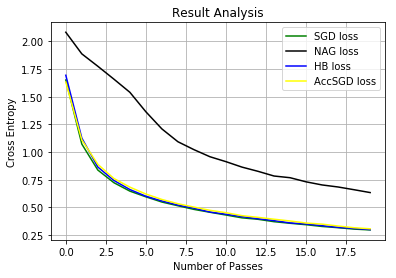

In [0]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

#x_axix=xxAccSGD.tolist()
#y_axix1=yymomentum.tolist()
#y_axix5=yyAccSGD.tolist()

#print("yyAdam=",yyAccSGD)
#x_axix，train_pn_dis这些都是长度相同的list()
 
#开始画图
sub_axix = filter(lambda x:x%200 == 0, x_axix)
plt.title('Result Analysis')
#plt.plot(x_axix, y_axix1, color='red', label='momentum loss')
plt.plot(x_axix, ySGD, color='green', label='SGD loss')
plt.plot(x_axix, yNAG, color='black', label='NAG loss')
plt.plot(x_axix, yHB, color='blue', label='HB loss')
plt.plot(x_axix, yAccSGD, color='yellow', label='AccSGD loss')
#plt.plot(x_axix, y_axix6, color='skyblue', label='Adam loss')
plt.legend() # 显示图例
 
plt.xlabel('Number of Passes')
plt.ylabel('Cross Entropy')
plt.grid(axis='both')
plt.show()
